In [1]:
library(FactoMineR)
library(factoextra)
library(corrplot)
library(gridExtra)
options(repr.plot.width=15, repr.plot.height=9)

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.84 loaded



In [2]:
# Lecture des données
d <- read.csv("https://auder.net/miage/B_seance3-4_ACP/data/owid-covid-data_EDIT_13-10-2020.csv")
# Suppression de la première colonne, utilisée comme label (codes pays)
rownames(d) <- d[,1]
d <- d[,-1]

## Question 0

Première étape : comprendre ce que représentent les variables. Pour la plupart c'est plutôt clair, mais il y a quelques subtilités :

| Variable                  | Signification                                                                     |
| ---                       | ---                                                                               |
|iso_code                   | Code ISO du pays                                                                  |
|continent                  | ...Continent :-)                                                                  |
|location                   | Nom du pays                                                                       |
|total_cases_per_million    | Somme des cas enregistrés jusqu'au 13 octobre inclus, par million d'habitant      |
|total_deaths_per_million   | Nombre de décès jusqu'au 13 octobre inclus, par million d'habitants               |
|population_density         | Nombre d'habitants par kilomètre carré en moyenne                                 |
|median_age                 | Âge médian : 50% de la population est plus jeune, l'autre moitié est plus vieille |
|aged_65_older              | Pourcentage de +65 ans                                                            |
|aged_70_older              | Pourcentage de +70 ans                                                            |
|gdp_per_capita             | PIB par habitant                                                                  |
|diabetes_prevalence        | Pourcentage de diabétiques                                                        |
|hospital_beds_per_thousand | Nombre de lits d'hôpital pour 1000 habitants                                      |
|life_expectancy            | ...Espérance de vie :-)                                                           |
|human_development_index    | Indice de développement basé sur le PIB, l'espérance de vie et l'éducation        |

## Question 1

### Analyse descriptive

In [3]:
# Calcul de l'ACP
res.pca <- PCA(d, quali.sup=c(1,2), graph=FALSE)

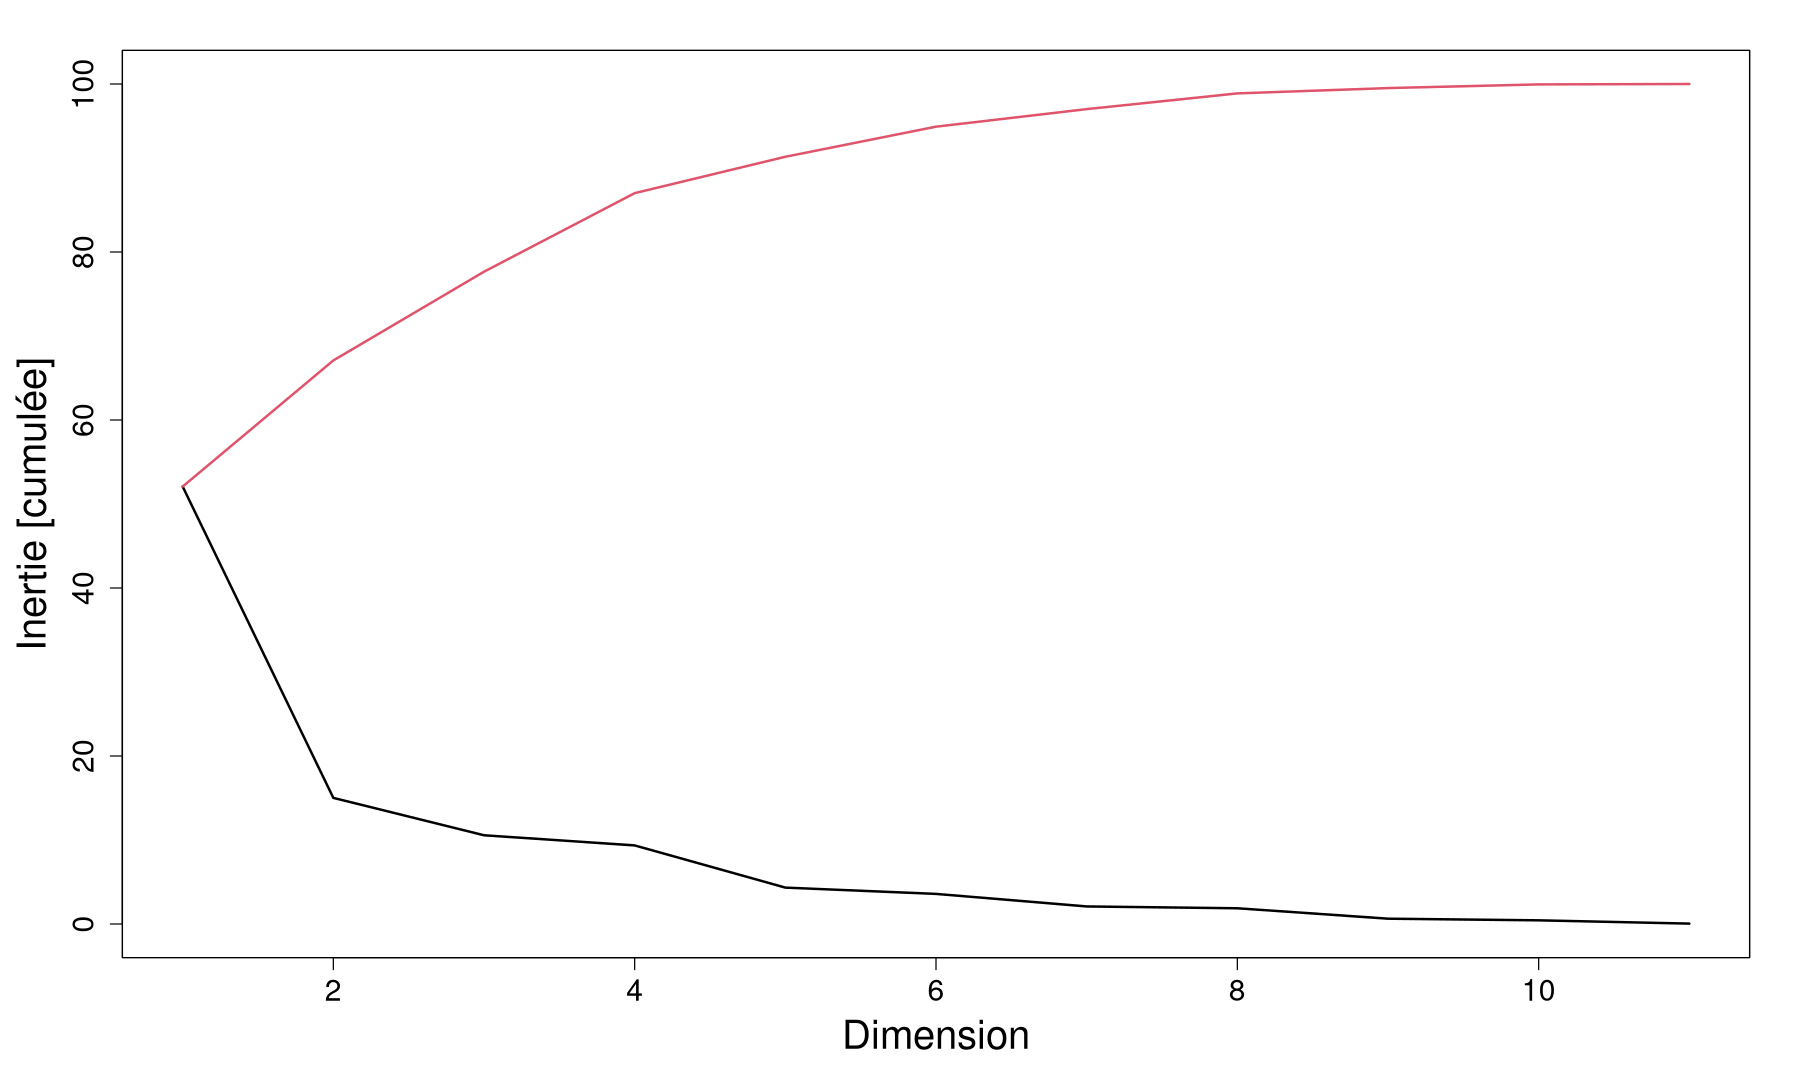

In [4]:
# Inerties sur chaque axe :
par(mar=c(5.1, 5.1, 2.1, 2.1))
plot(res.pca$eig[,2], xlab="Dimension", ylab="Inertie [cumulée]", ylim=c(0,100),
     type="l", lwd=2, cex.axis=1.5, cex.lab=2)
par(new=TRUE)
plot(res.pca$eig[,3], xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,100), type="l", lwd=2, col=2)

La figure suggère de garder 4 axes pour capter +80% de l'inertie. Vérification numérique :

In [5]:
res.pca$eig[,3][1:4]

comp 1   comp 2   comp 3   comp 4 
52.07891 67.09137 77.65423 87.00791

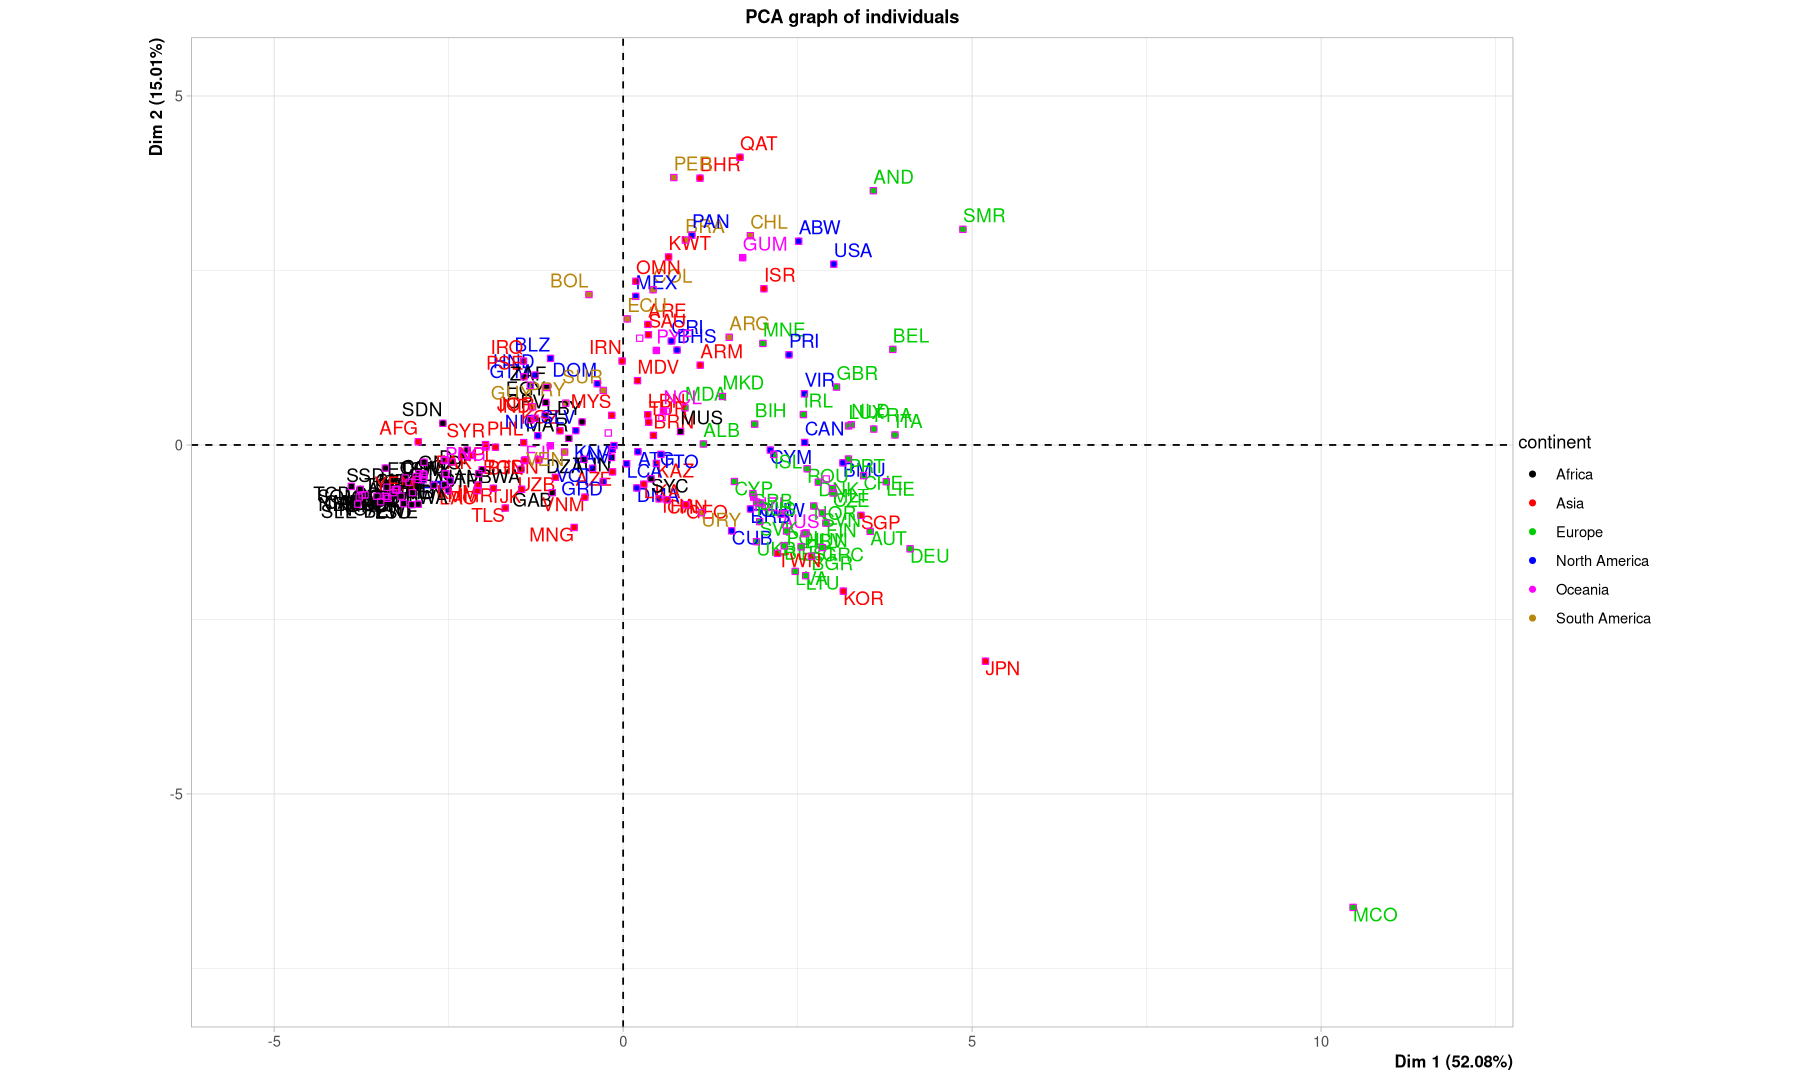

In [6]:
# Nuage des individus
plot(res.pca, axes=c(1,2), choix="ind", habillage=1, label="ind")

Deux groupes ressortent nettement : les payes d'Afrique en noir à gauche, et les pays européens en vert sur la droite. Les pays des trois autres continents se retrouvent représentés en général plus au centre, et sans se détacher des deux autres.

Monaco, en bas à droite, pose question : il faudra sans doute le retirer de l'analyse. Examinons cet individu de plus près d'abord.

In [7]:
monaco_idx <- (1:nrow(d))[d[,2] == "Monaco"]
rbind(d[monaco_idx,3:ncol(d)], AVG=colMeans(d[-monaco_idx,3:ncol(d)]))[,c(2,3,4,7,9,11)]

total_deaths_per_million population_density median_age gdp_per_capita
MCO  25.4820                 19347.5000         53.80000   185741.28     
AVG 130.7234                   216.4659         30.79259    19801.88     
    hospital_beds_per_thousand human_development_index
MCO 13.800000                  0.9560000              
AVG  2.834921                  0.7156138

On constate des valeurs particulièrement atypiques : (relativement) très peu de morts, une énorme densité de population, dont plus de 50% dépasse les 54 ans. Enfin, un PIB particulièrement élevé, corrélé à un (relatif) grand nombre de lits d'hôpital et un indice de développement humain très élevé.

Regardons aussi les quelques autres pays les plus riches :

In [8]:
sort_gdp <- sort(d[["gdp_per_capita"]], decreasing=TRUE, index.return=TRUE)
d[sort_gdp$ix[1:6],c(2,4,5,6,9,11,13)]

location      total_deaths_per_million population_density median_age
MCO Monaco         25.482                  19347.500          53.8      
LIE Liechtenstein  26.221                    237.012          43.4      
QAT Qatar          76.361                    227.322          31.9      
LUX Luxembourg    212.468                    231.447          39.7      
SGP Singapore       4.786                   7915.731          42.4      
BRN Brunei          6.857                     81.347          32.4      
    gdp_per_capita hospital_beds_per_thousand human_development_index
MCO 185741.28      13.800                     0.956                  
LIE 165028.25       2.397                     0.916                  
QAT 116935.60       1.200                     0.856                  
LUX  94277.96       4.510                     0.904                  
SGP  85535.38       2.400                     0.932                  
BRN  71809.25       2.700                     0.853

L'individu qui serait le plus proche de Monaco est le Liechtenstein, mais ce dernier affiche tout de même une densité de population nettement moindre, ainsi qu'un âge médian plus jeune de 10 ans, et un nombre de lits d'hôpital dans la moyenne. Monaco étant clairement un cas extrême, on considère qu'il ne peut contribuer à l'étude du reste du groupe, et on continue donc sans lui.

In [9]:
d <- d[-monaco_idx,]

In [10]:
# Actualisation de l'ACP :
res.pca <- PCA(d, quali.sup=c(1,2), graph=FALSE)

In [11]:
# Inertie cumulée :
res.pca$eig[,3][1:4]

comp 1   comp 2   comp 3   comp 4 
51.20537 65.95258 77.21930 85.34088

L'inertie totale diminue légèrement, ce qui est logique car on a retiré un individu très éloigné du centre de gravité. Elle reste cependant du même ordre : 85 au lieu de 87% avec 4 axes.

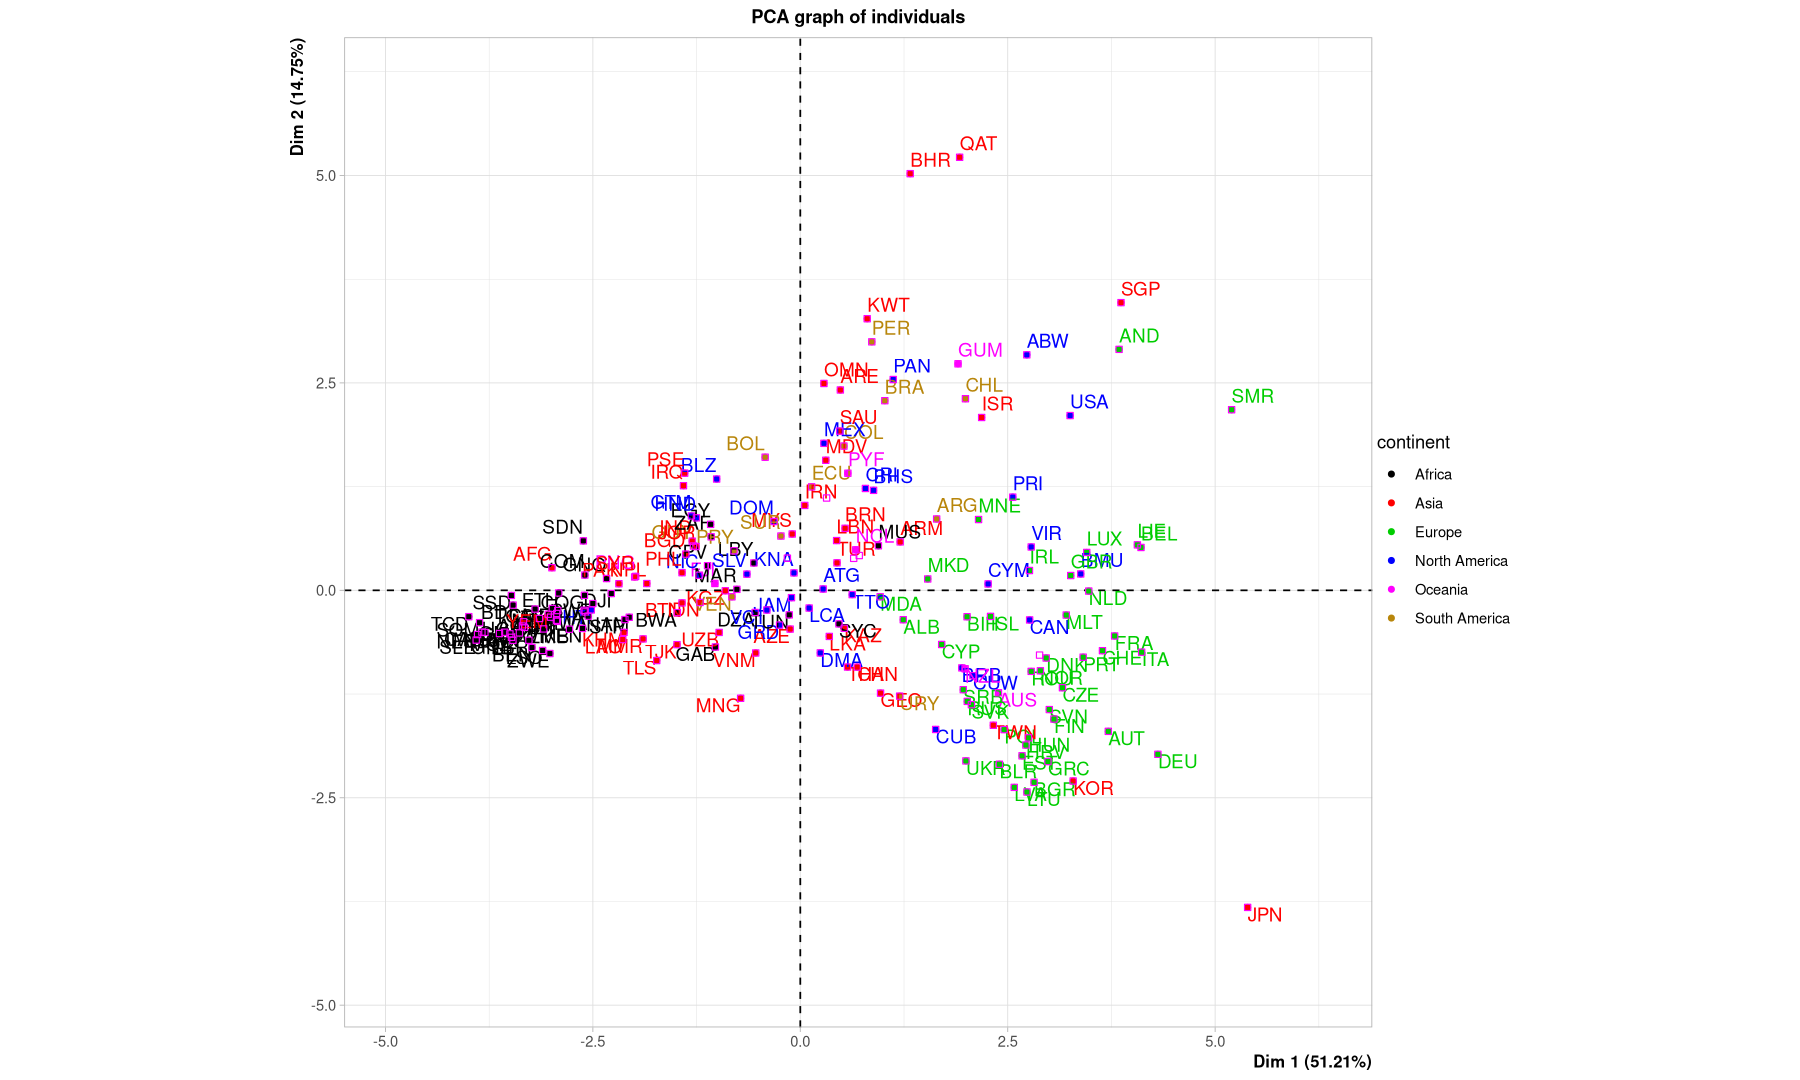

In [12]:
# Nuage des individus : on y voit maintenant plus clair
plot(res.pca, axes=c(1,2), choix="ind", habillage=1, label="ind")

L'impression visuelle est inchangée : Europe à droite, Afrique à gauche (avec une variance plus faible : les pays se ressemblent plus que les pays européens entre eux), les autres continents plutôt au centre. On commence cependant à visualiser l'Asie "plutôt à gauche de l'Amérique du Nord", et l'Amérique du Sud "plutôt au-dessus des deux autres continents". Vérification en traçant les ellipses de confiance :

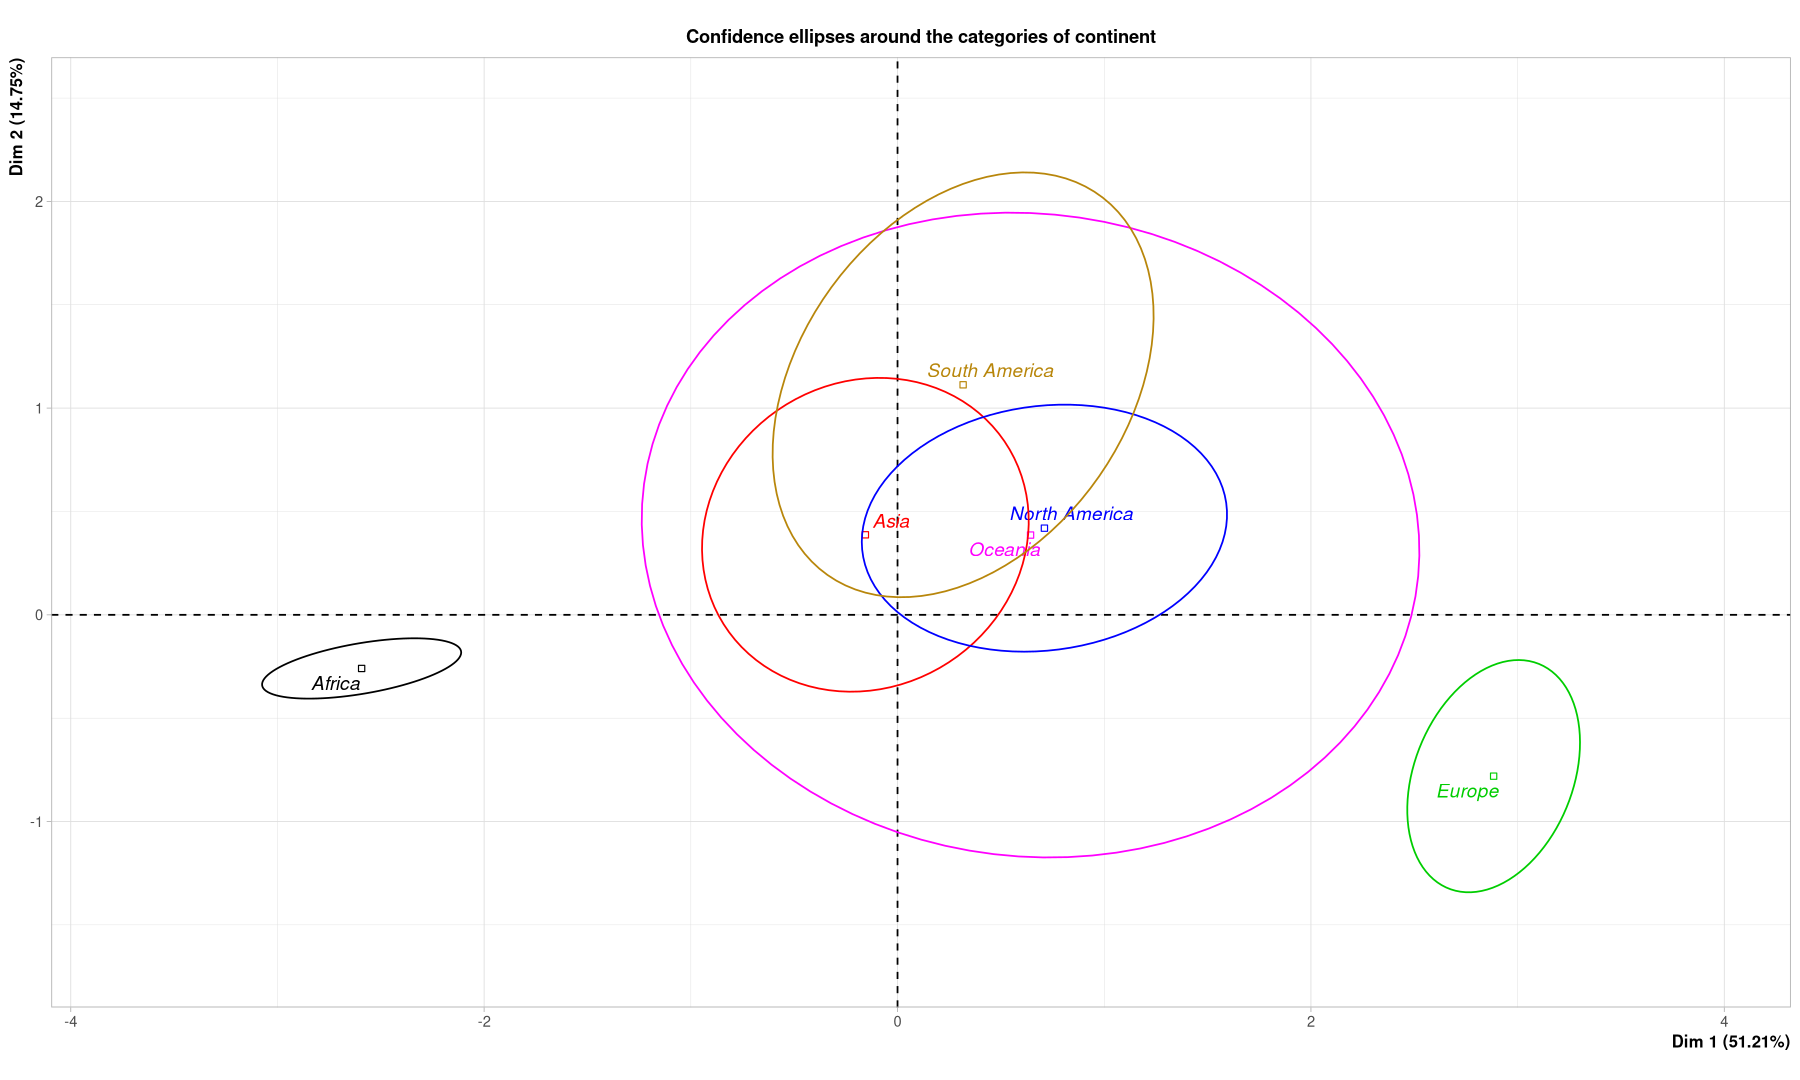

In [13]:
plotellipses(res.pca, keepvar="continent", invisible=c("ind"), level=0.99)

Un individu atypique subsiste : le Japon, du même type que Monaco (tout en bas à droite). Dans la mesure où il ne gêne pas l'analyse, il n'y a cependant pas de raison de le supprimer.

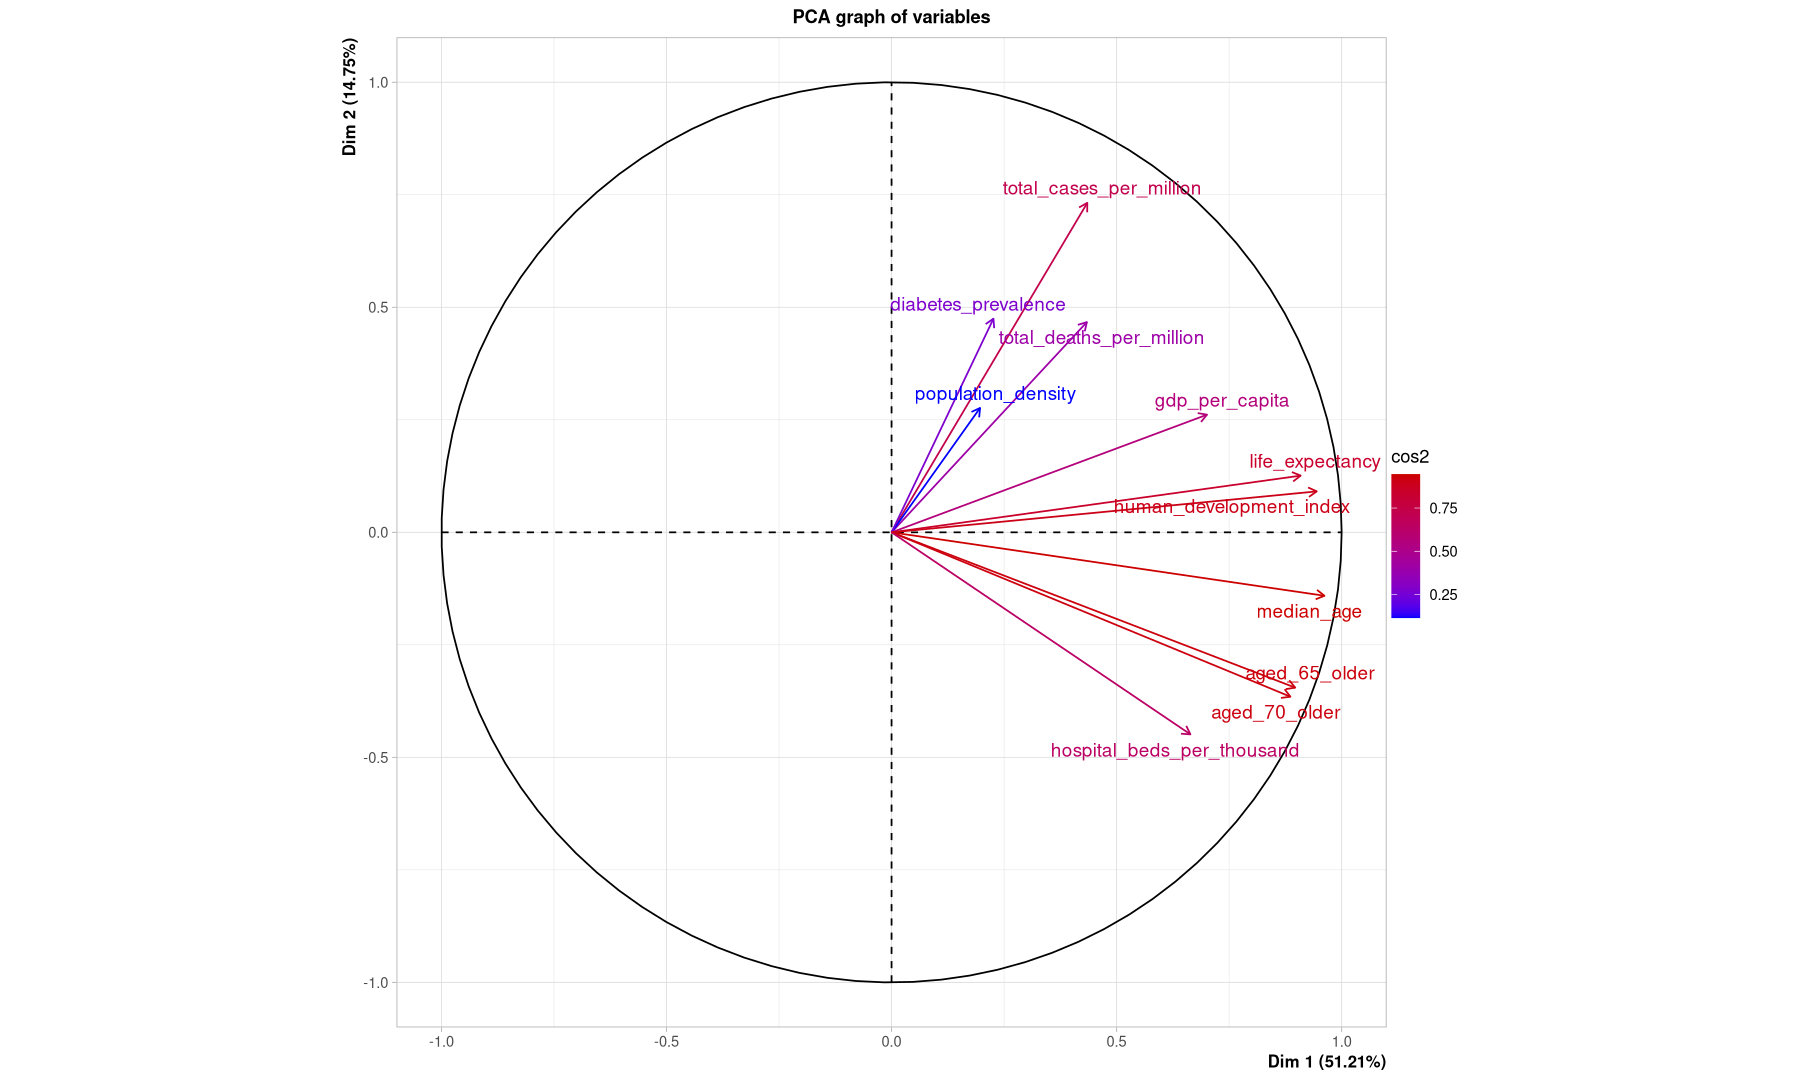

In [14]:
# Cercle des corrélations
plot(res.pca, axes=c(1,2), choix="var", habillage="cos2")

L'interprétation du premier axe est claire : quasi parfaitement corrélé à l'indice de développement humain, lui-même fortement corrélé avec l'espérance de vie ou l'âge médian ; bref ce premier axe comptant pour la moitié de l'inertie représente la richesse d'un pays, son niveau de développement.

Au passage, les corrélations (positives) très fortes entre les paires de variables âge supérieur à 65 / 70 ans et IDH et espérance de vie mènent à supprimer une sur deux de ces variables. On enlèvera donc "aged_70_older" et "life_expectancy", assez arbitrairement.

Le second axe est plus difficile à interpréter. Il semble a priori plutôt représenter l'impact du covid, avec une grande corrélation avec "total_cases_per_million", mais c'est moins net que pour le premier.

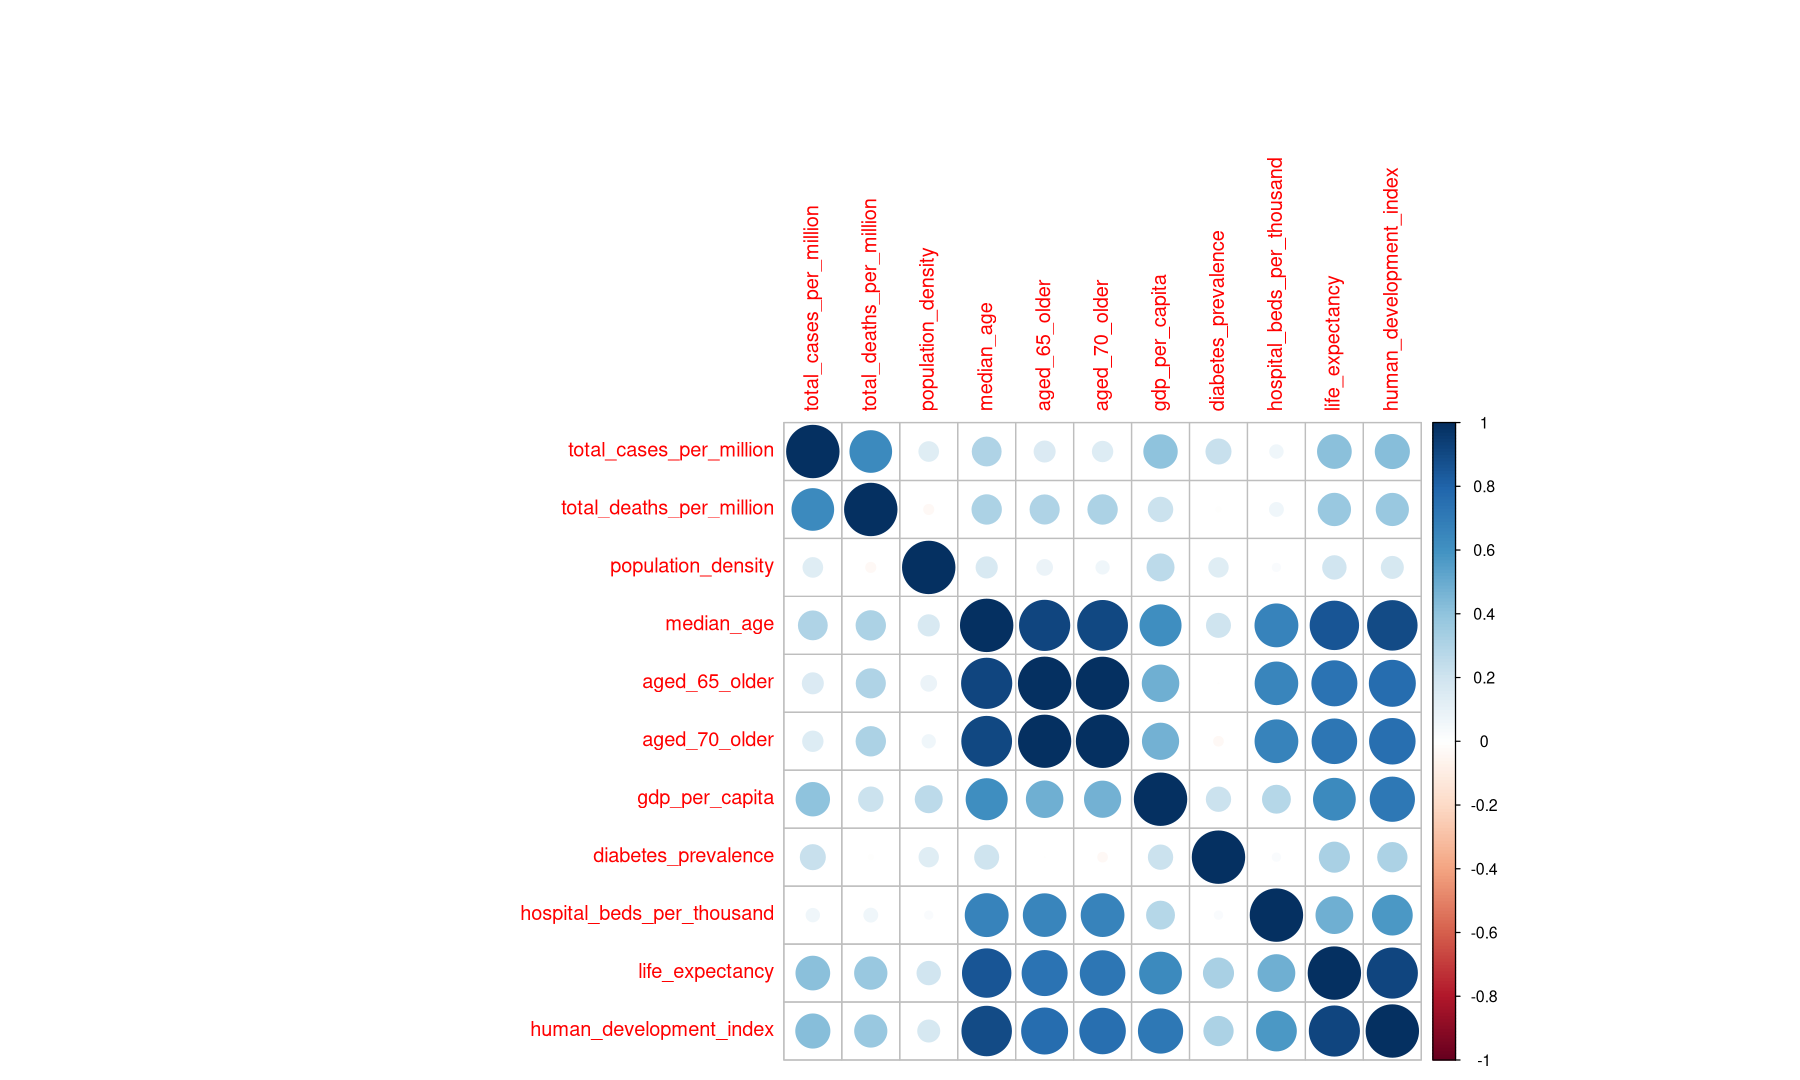

In [15]:
corrplot(cor(d[,3:ncol(d)]))
# Seconde vérification graphique des redondances inter-variables :

In [16]:
# Relançons l'analyse après suppression des deux variables mentionnées ci-dessus :
d <- subset(d, select=!(colnames(d) %in% c("aged_70_older","life_expectancy")))

In [17]:
# Actualisation de l'ACP :
res.pca <- PCA(d, quali.sup=c(1,2), graph=FALSE)

In [18]:
# Inertie cumulée :
res.pca$eig[,3][1:4]

comp 1   comp 2   comp 3   comp 4 
45.25415 61.68497 75.11085 84.90466

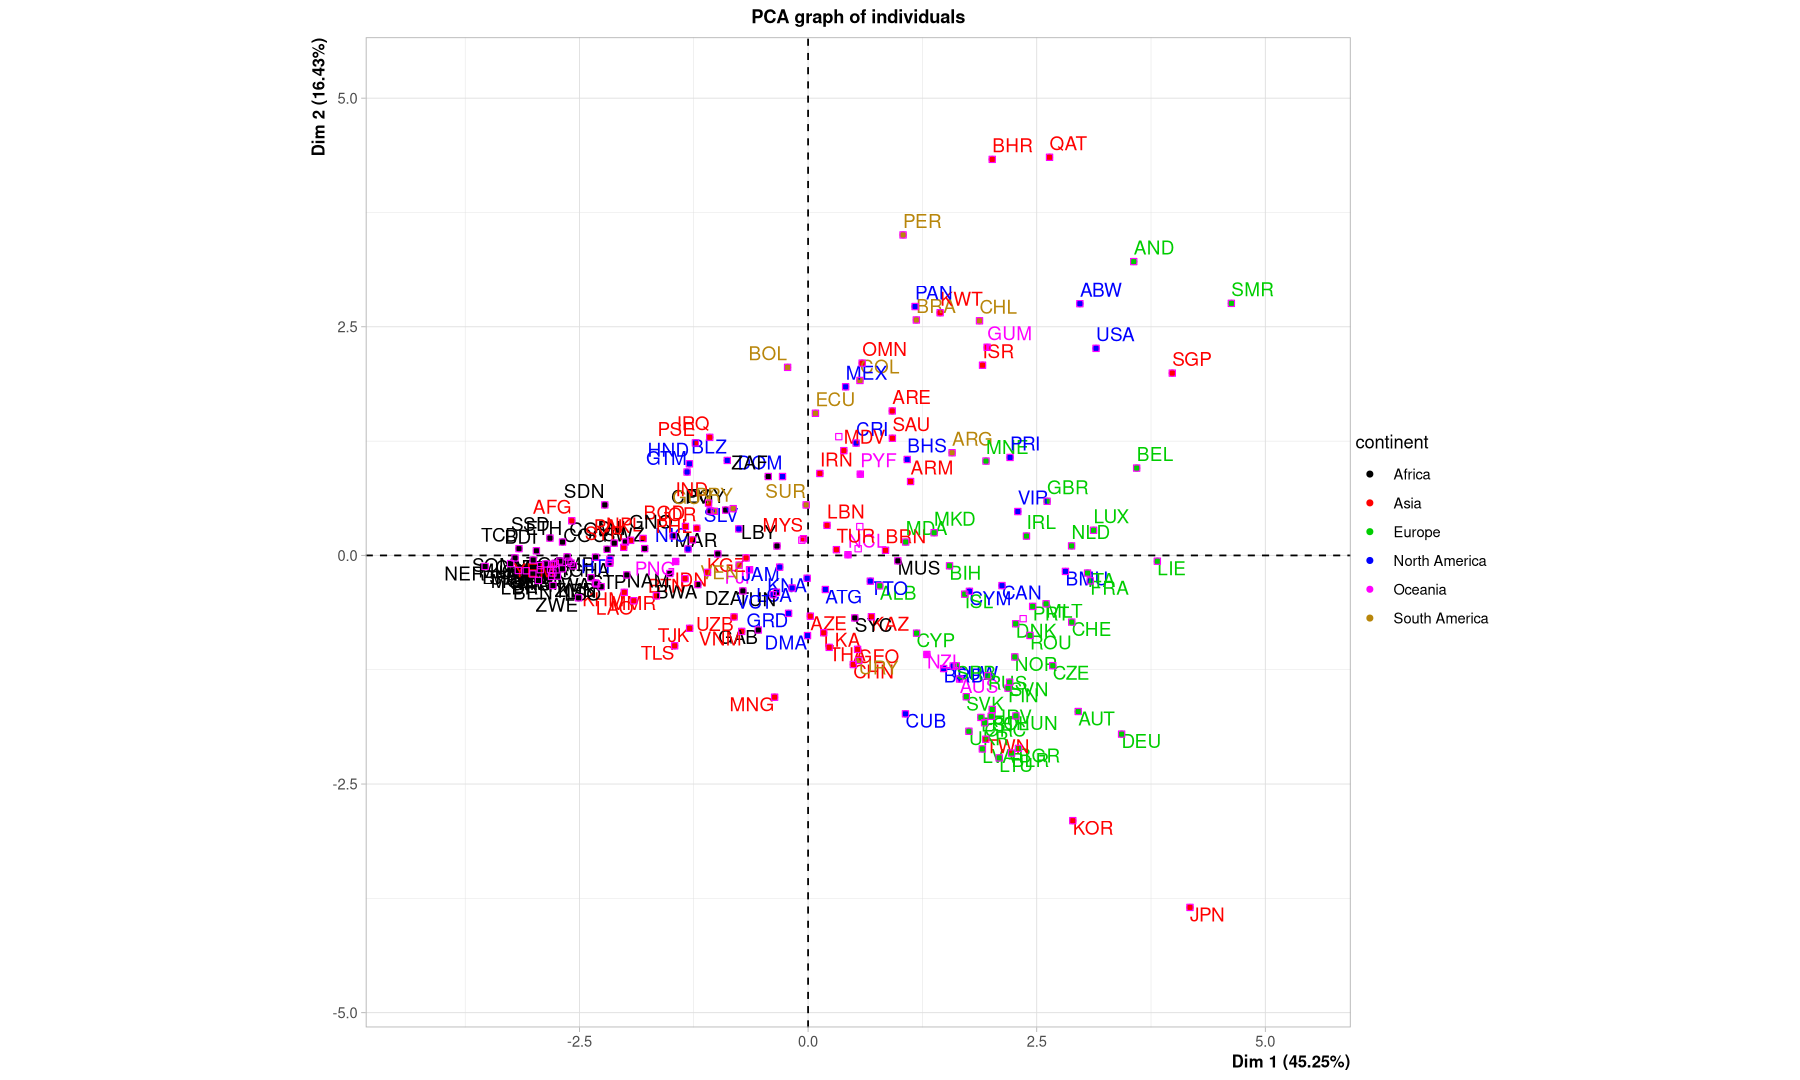

In [19]:
# Nuage des individus : pas de bouleversements, Singapour et la Corée descendent un peu par exemple.
plot(res.pca, axes=c(1,2), choix="ind", habillage=1, label="ind")

Au niveau de l'inertie cumulée, on note que les composantes 3 et 4 prennent plus d'importance comparé à la situation précédente : 61% dans le premier plan au lieu de 67, mais toujours 85% au total sur les quatre premiers axes.

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


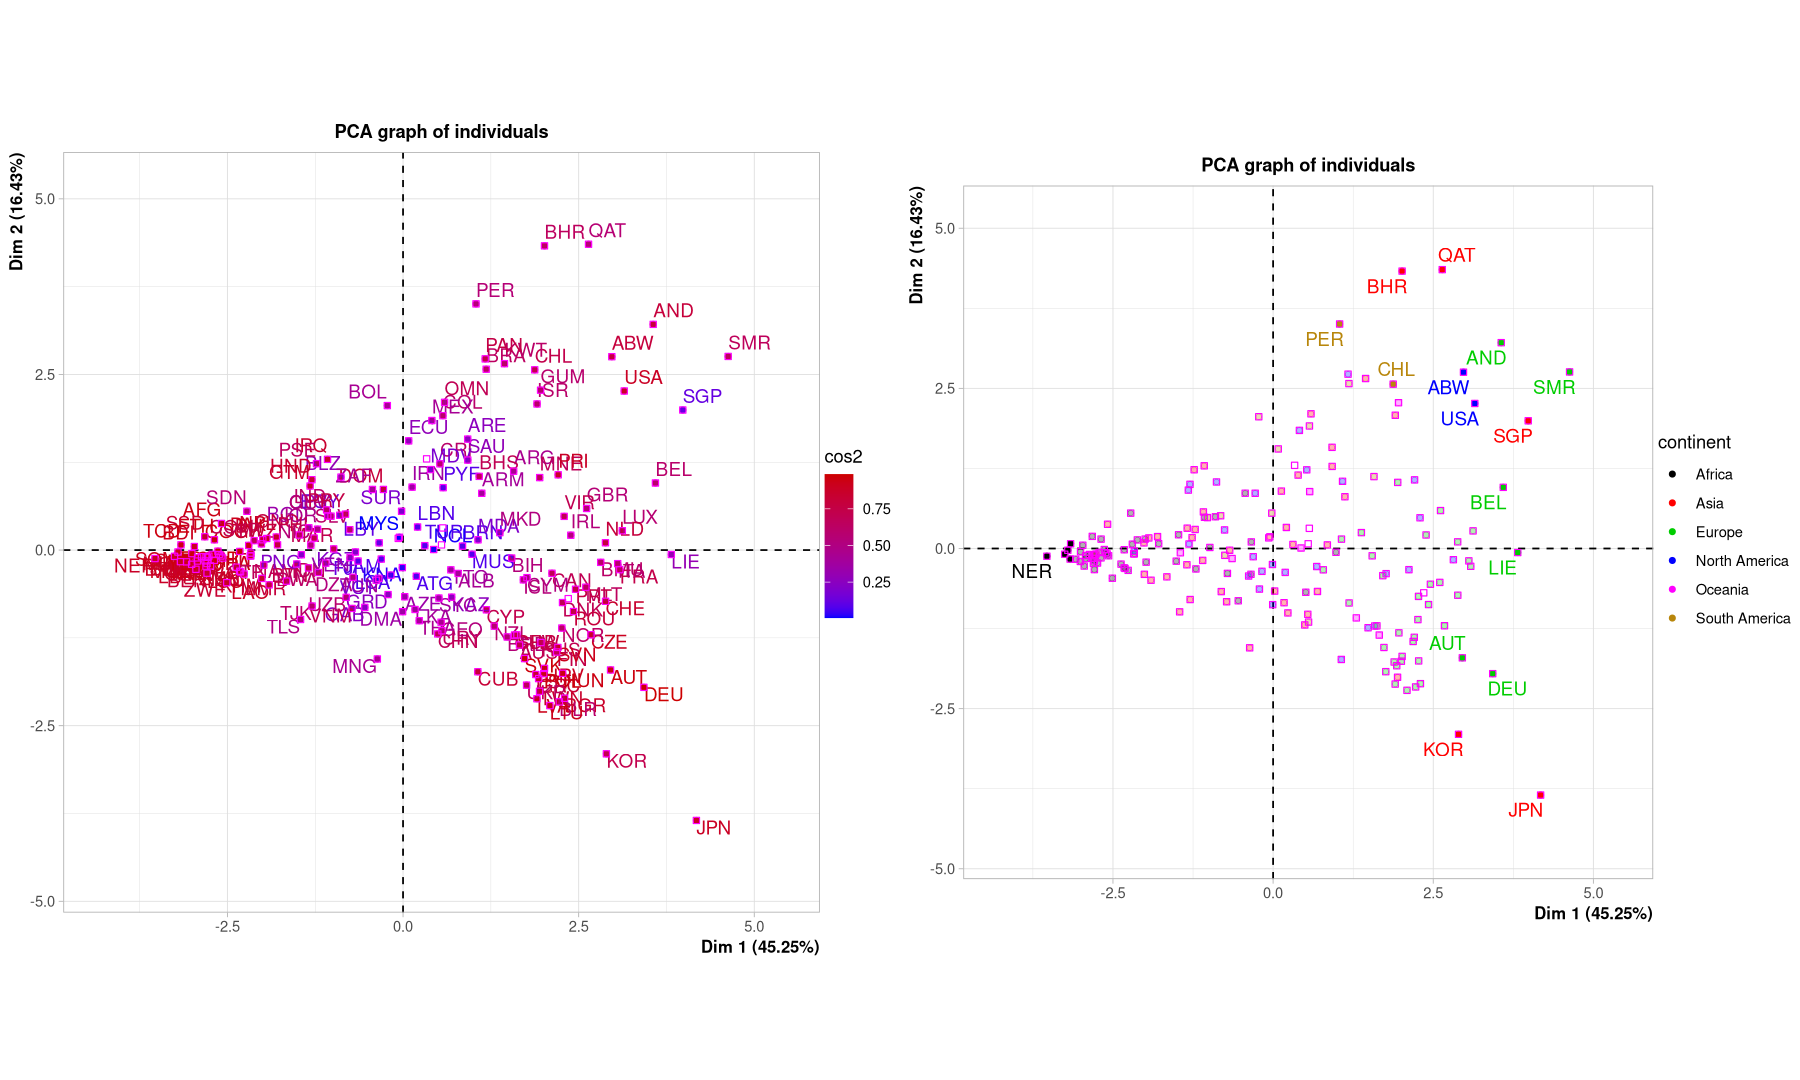

In [20]:
# Qualité de projection des individus + individus contribuant le plus
grid.arrange(plot(res.pca, axes=c(1,2), choix="ind", habillage="cos2", label="ind"),
             plot(res.pca, axes=c(1,2), choix="ind", habillage=1, select="contrib 20", label="ind"), ncol=2)

Sans surprise, les pays aux plus fortes contributions sont les points extrêmes du nuage des individus. Ensuite, on remarque que la plupart des pays proches du centre de gravité sur ce plan sont très mal projetés (note : Singapour également). Cela signifie qu'il faudra les regarder sur le plan 3-4.

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


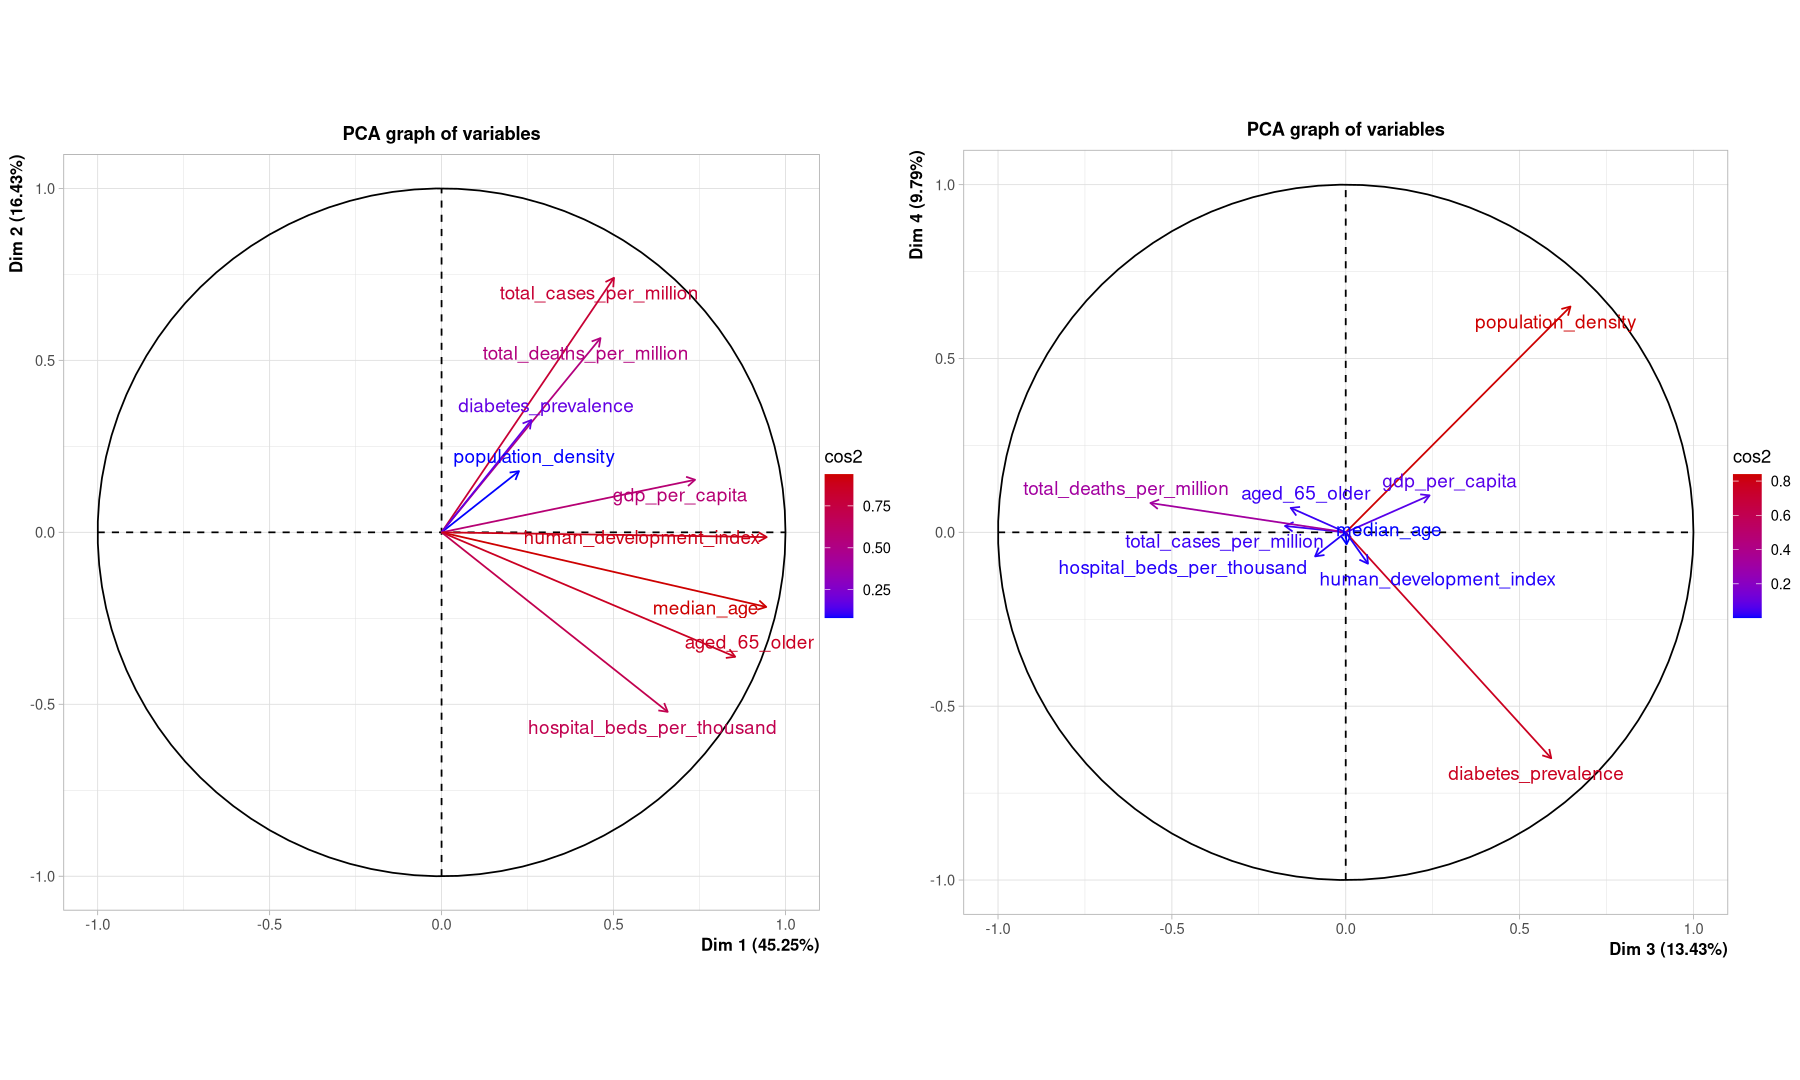

In [21]:
# Cercles des corrélations : pas de changements notables sur le plan 1-2
grid.arrange(plot(res.pca, axes=c(1,2), choix="var", habillage="cos2"),
             plot(res.pca, axes=c(3,4), choix="var", habillage="cos2"), ncol=2)

On observe sur ces cercles la quasi-orthogonalité des (bonnes) représentations des variables "total_cases_per_million" et "hospital_beds_per_thousand". Autrement dit, il n'y a pas de corrélation observée entre le nombre de cas et le nombre de lits disponibles, ce qui semble logique. De même pour le couple densité de population / prévalence du diabète (assez logique également, on ne voit a priori pas le rapport).

Les axes sur le plan 3-4 sont plus difficiles à expliquer. Il semble que la densité de population augmente en direction nord-est, tandis que la prévalence du diabète augmente selon la direction sud-est.

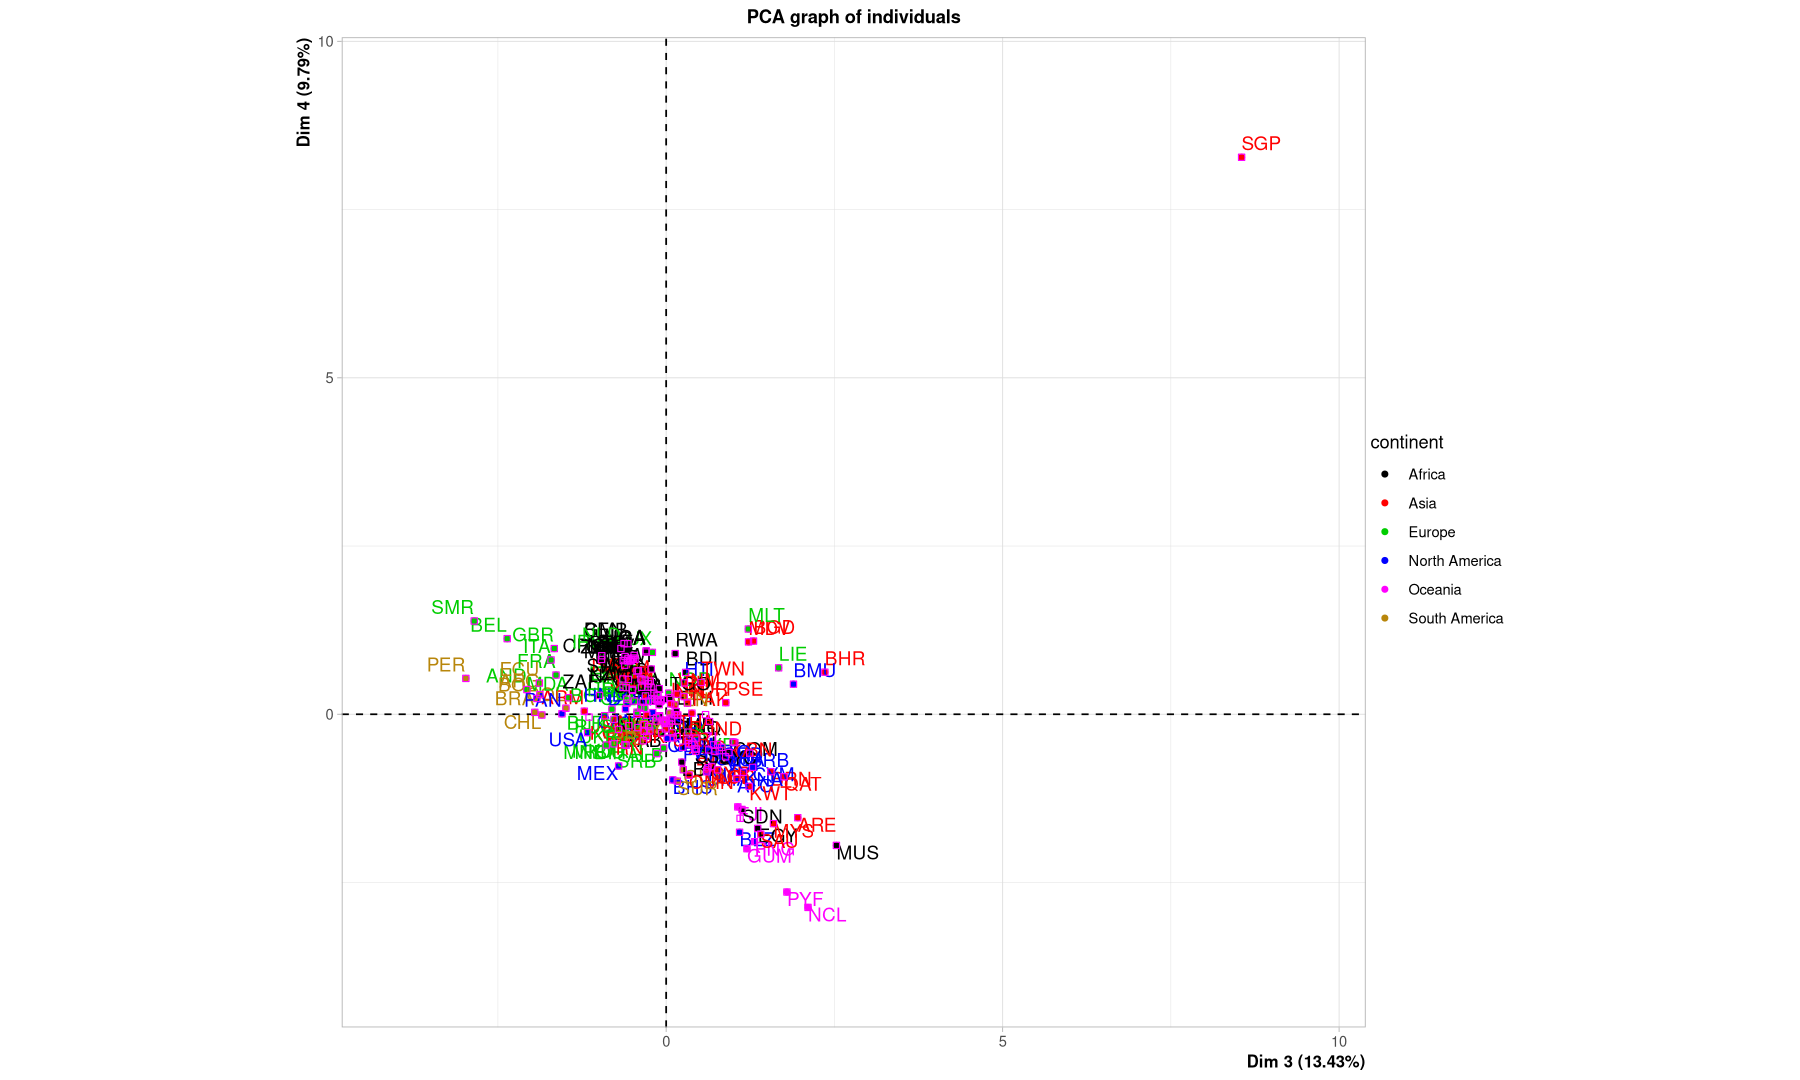

In [22]:
# Vérification sur le nuage des individus sur les axes 3-4 (23% d'inertie environ)
plot(res.pca, axes=c(3,4), choix="ind", habillage=1, label="ind")

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


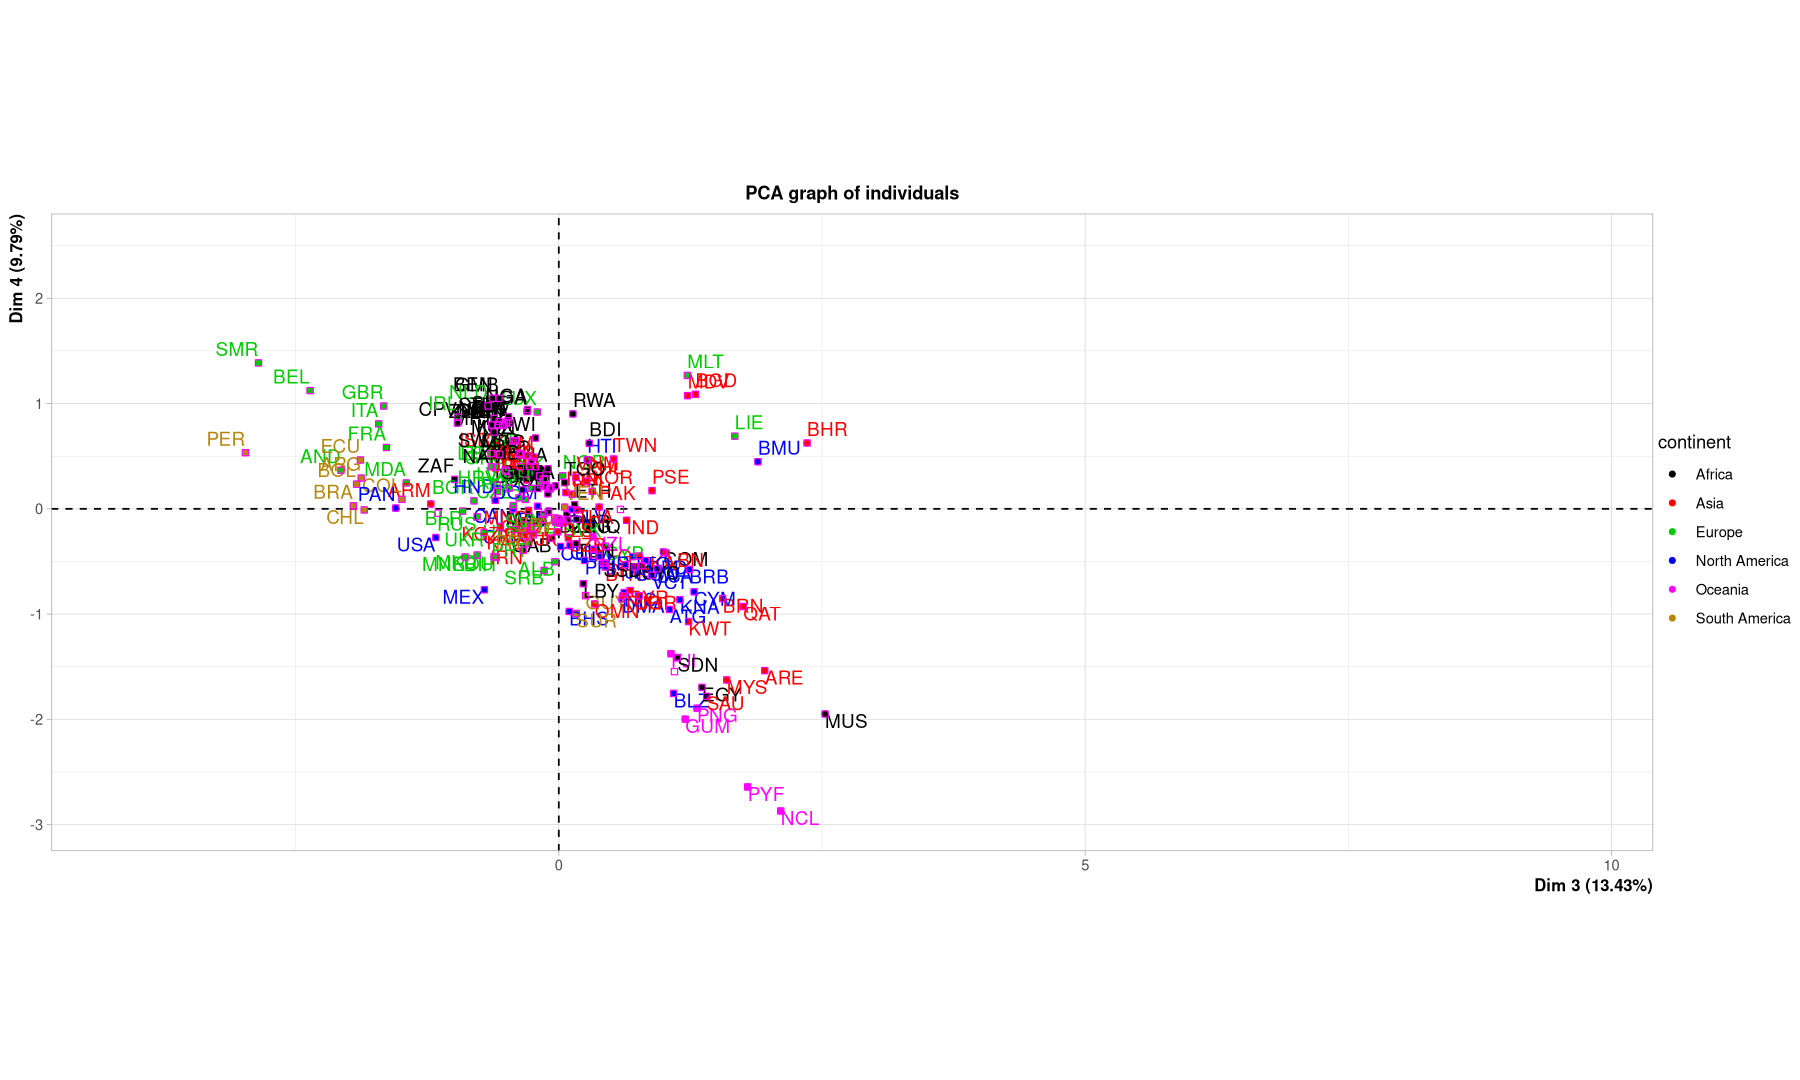

In [23]:
# Singapour est un point extrême sur ce nuage : supprimons le seulement pour le tracé.
singapour_idx <- (1:nrow(d))[d[,2] == "Singapore"]
ylim <- range(res.pca$ind$coord[-singapour_idx,3:4])
plot(res.pca, axes=c(3,4), choix="ind", habillage=1, label="ind", ylim=ylim)

In [24]:
# Vérification avec deux points extrêmes, et un central :
show_idx <- (1:nrow(d))[rownames(d) %in% c("USA","IDN","BHR")]
subset(d[show_idx,], select=c("location", "population_density"))
range(d[["population_density"]])

location      population_density
BHR Bahrain       1935.907          
IDN Indonesia      145.725          
USA United States   35.608

[1]    1.980 7915.731

In [25]:
# Puis, sur l'autre axe concernant la prévalence du diabète :
show_idx <- (1:nrow(d))[rownames(d) %in% c("NCL","UZB","SMR")]
subset(d[show_idx,], select=c("location", "diabetes_prevalence"))
range(d[["diabetes_prevalence"]])

location      diabetes_prevalence
NCL New Caledonia 23.36              
SMR San Marino     5.64              
UZB Uzbekistan     7.57

[1]  0.99 23.36

On observe également une certaine corrélation négative sur l'axe 4 avec le nombre de morts par million. Vérifions :

In [26]:
# Puis, sur l'autre axe concernant la prévalence du diabète :
show_idx <- (1:nrow(d))[rownames(d) %in% c("PER","BMU","SGP")]
subset(d[show_idx,], select=c("location", "total_deaths_per_million"))
range(d[["total_deaths_per_million"]])

location  total_deaths_per_million
BMU Bermuda    144.525                
PER Peru      1011.681                
SGP Singapore    4.786

[1]    0.000 1237.551

### Tentative avec variables supplémentaires

Essayons maintenant de considérer les variables "statistiques covid" comme supplémentaires : nombre de cas et de décès totaux.

In [27]:
# Recalcul de l'ACP
res.pca <- PCA(d, quali.sup=c(1,2), quanti.sup=c(3,4), graph=FALSE)

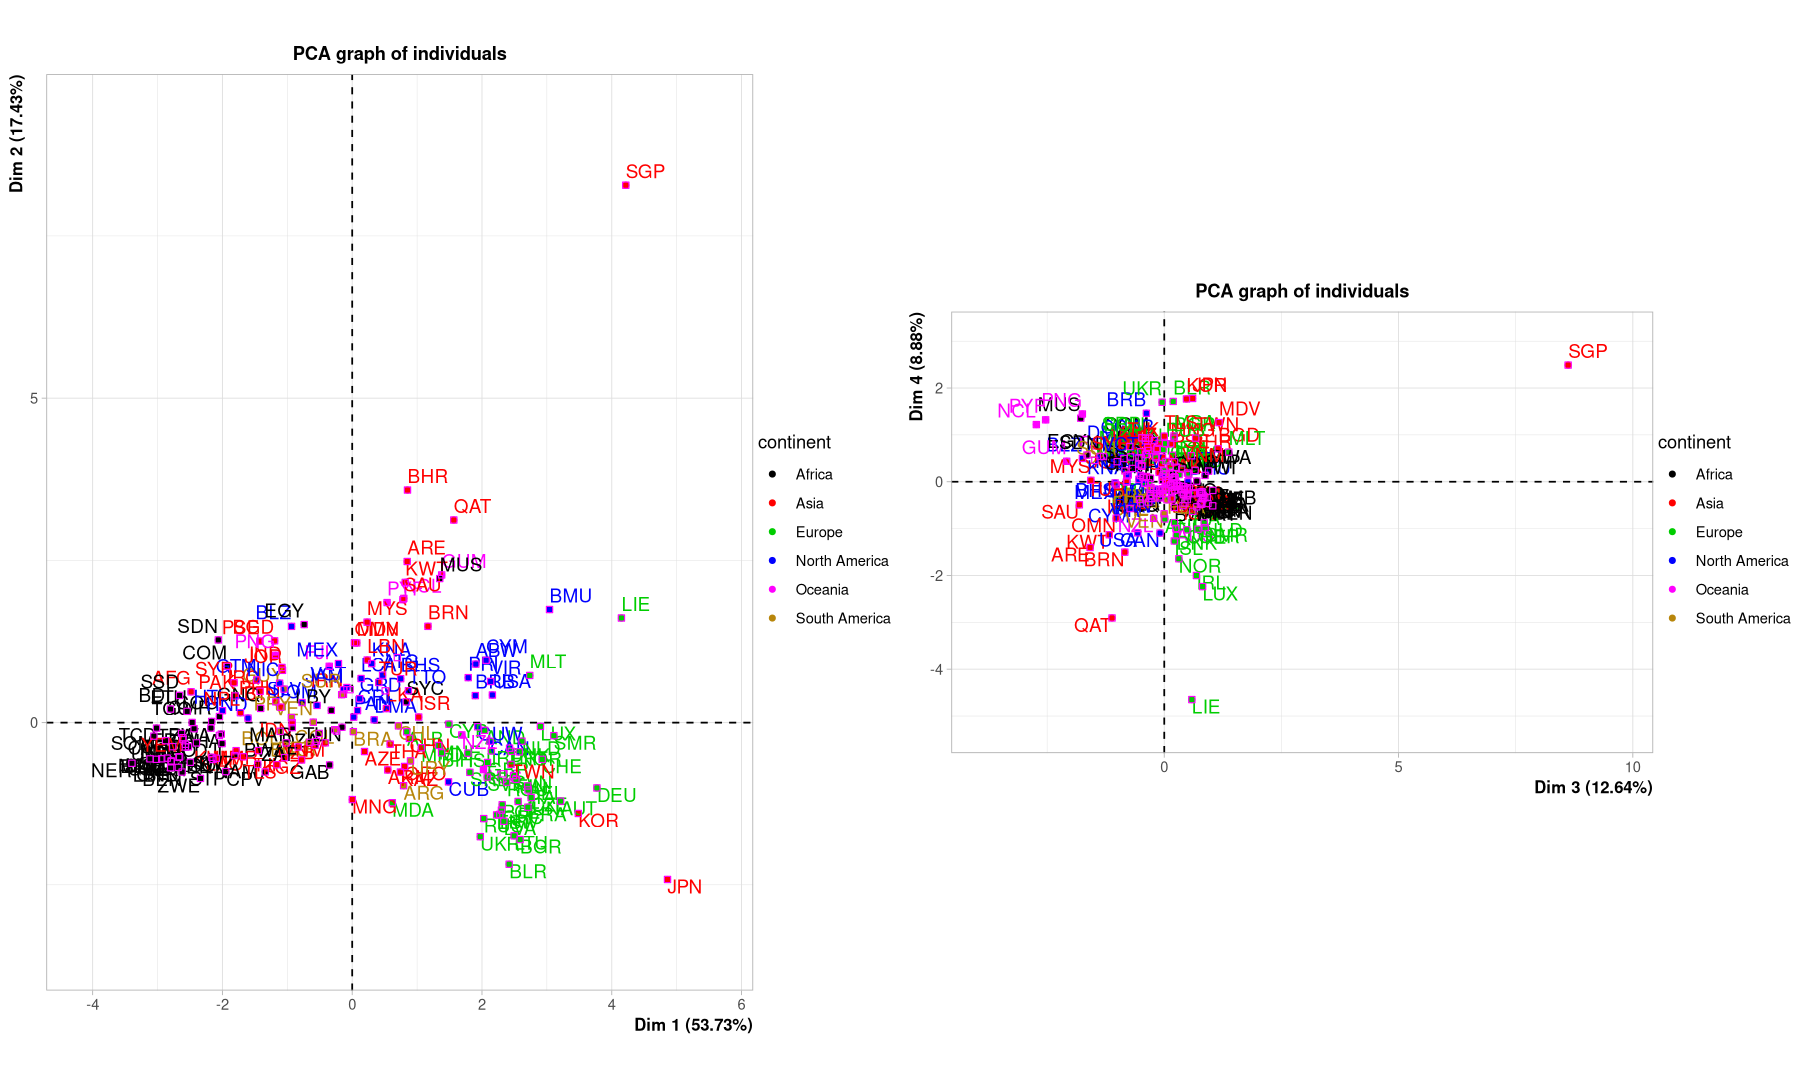

In [28]:
# Nuage des individus : même allure qu'auparavant sur le plan 1-2, changement sur le plan 3-4
grid.arrange(plot(res.pca, axes=c(1,2), choix="ind", habillage=1, label="ind"),
             plot(res.pca, axes=c(3,4), choix="ind", habillage=1, label="ind"), ncol=2)

Plan 1-2 : les représentations des pays européens semblent tout de même moins dispersées qu'auparavant. Enfin, il est amusant de constater que le plus proche voisin de la Corée sur ce nuage soit l'Autriche.

Plan 3-4 : le nuage n'a pas de direction particulière, on sent que ce plan va être moins intéressant.

Enfin, regardons l'inertie cumulée :

In [29]:
res.pca$eig[,3][1:4]

comp 1   comp 2   comp 3   comp 4 
53.73336 71.15903 83.79711 92.67697

Plus de 92% expliqués par les quatre premiers axes, donc à peine plus de 20% par les axes 3 et 4. C'est cohérent : plus on enlève de variables, plus les nouvelles variables synthétiques peuvent offrir un bon résumé. Dans le cas extrême à 4 variables, on expliquerait 100%.

Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_text).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


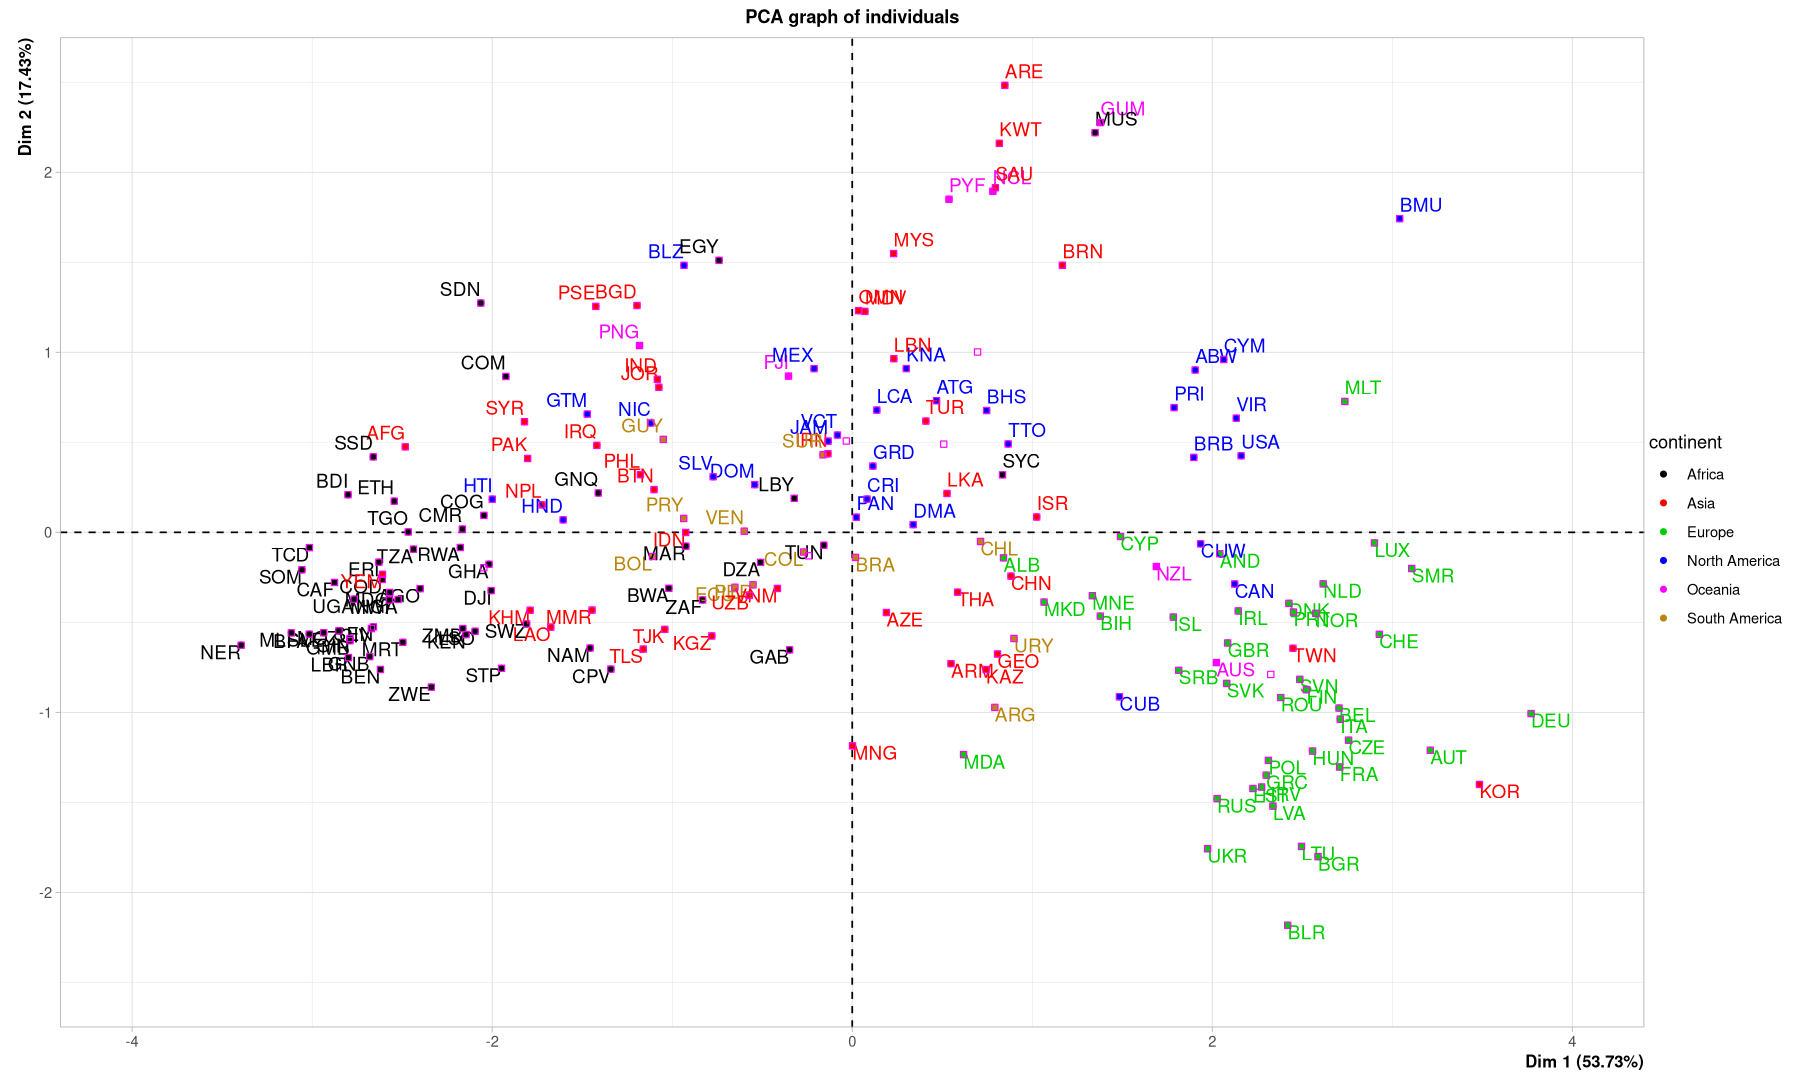

In [30]:
# Zoom violent pour y voir un peu plus clair : (perdant quelques pays)
plot(res.pca, axes=c(1,2), choix="ind", habillage=1, label="ind", xlim=c(-4,4), ylim=c(-2.5,2.5))

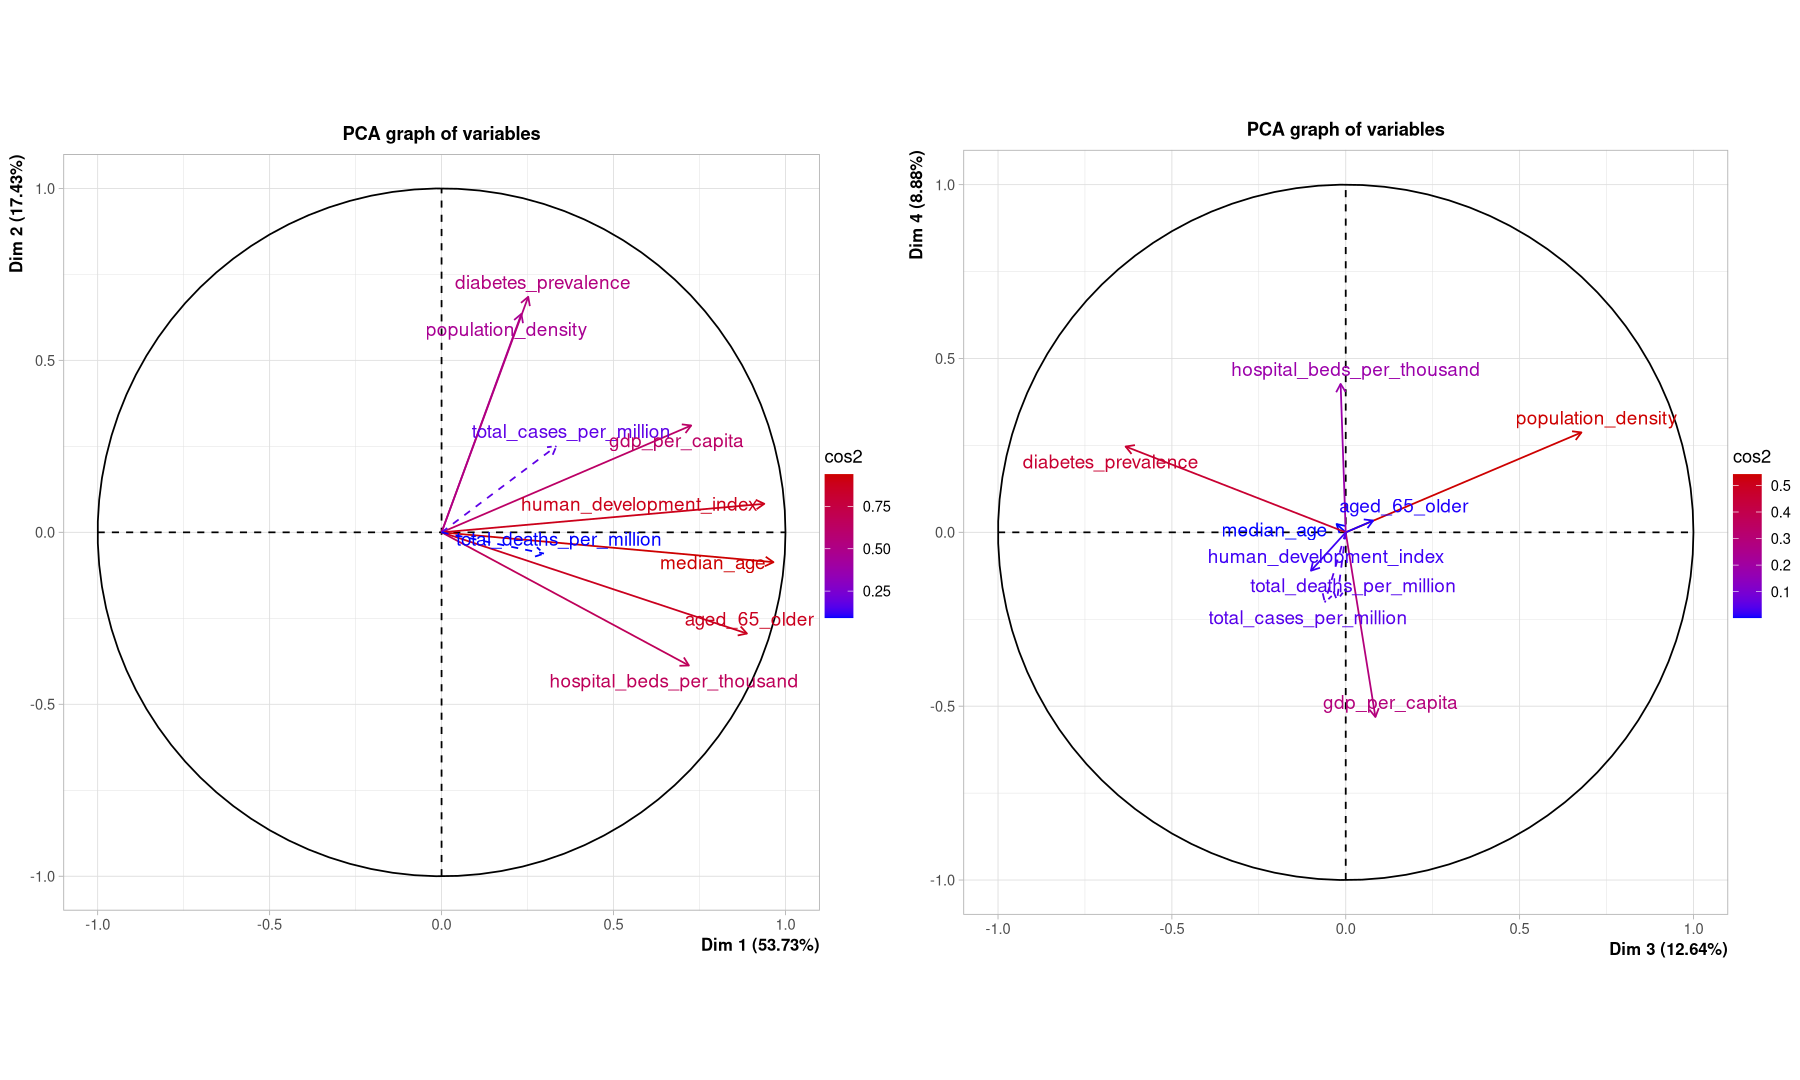

In [31]:
# Cercle des corrélations
grid.arrange(plot(res.pca, axes=c(1,2), choix="var", habillage="cos2"),
             plot(res.pca, axes=c(3,4), choix="var", habillage="cos2"), ncol=2)

Les variables supplémentaires sont très mal projetées : cela semble indiquer que l'impact du covid, finalement, est assez indépendant des caractéristiques d'un pays. Il existe tout de même une corrélation légèrement positive entre le nombre de cas total et l'indice de développement d'un pays - qui résume plusieurs variables -, ainsi qu'entre le nombre total de morts et l'âge médian. Cela signifierait que le covid se propage plus dans les pays plus développés, et tue plus des populations plus vieilles. Si cette dernière affirmation est cohérente avec ce que l'on sait du virus, la première n'a pas vraiment de logique. On peut l'expliquer plutôt par le fait qu'un pays riche testera plus sa population, et donc verra forcément plus de cas. Enfin la petite corrélation "nombre de morts" et "indice de développement" (cf. tableau ci-dessous) indique que le covid a plus tendance à tuer dans les pays développés qu'ailleurs. Une possible explication réside dans l'idée qu'on peut se faire d'une population de pays riche : sujette au diabète, à l'obésité, avec beaucoup de personnes âgées. Il n'est pas étonnant alors que malgré toutes les mesures prises dans ces pays le nombre de morts soit relativement plus élevé.

In [32]:
# Vérification numérique des corrélations :
cor(subset(d, select=c("human_development_index","total_deaths_per_million","total_cases_per_million")))

human_development_index total_deaths_per_million
human_development_index  1.0000000               0.3749394               
total_deaths_per_million 0.3749394               1.0000000               
total_cases_per_million  0.4216821               0.6305615               
                         total_cases_per_million
human_development_index  0.4216821              
total_deaths_per_million 0.6305615              
total_cases_per_million  1.0000000

Il serait intéressant de regarder les statistiques sur les âges des personnes décédées. Quelques chiffres sont donnés concernant les États-Unis ici https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html

Notant $x$ le taux de décès de la tranche 18-29 ans, on obtient $(1/16 + 1/9 + 1 + 4 + 10 + 30) x \simeq 45 x$, pourcentage de décès chez les moins de 65 ans, et $(90 + 220 + 630) x = 940 x$ chez les plus de 65 ans, soit plus de 20 fois plus. Cela signifie que sur le total des morts de ce pays, seulement environ 16000 concernent des gens de moins de 65 ans (cf. https://ncov2019.live/). C'est moins de la moitié du nombre de tués sur les routes en 2019 dans ce même pays : https://www.nsc.org/road-safety/safety-topics/fatality-estimates.

## Question 2

In [33]:
system("wget https://covid.ourworldindata.org/data/owid-covid-data.csv")
# Put the header in a separate file
system("head -n1 owid-covid-data.csv > 13oct")
# Keep only lines referring to October 13
system("grep '.*,.*,.*,2020-10-13' owid-covid-data.csv >> 13oct")
# The character "'" seemingly has an issue with R CSV reading
system("sed -i 's/Cote d'Ivoire/Ivory Coast/' 13oct")

In [34]:
full_d <- read.csv("13oct")
# Remove redundant variables :
full_d <- subset(full_d, select=!(colnames(d) %in% c("aged_70_older","life_expectancy")))
# Some countries might be removed from the source (Russia, Afghanistan...).
# Also, some new countries might have appeared (they are ignored).
keep_idx <- rownames(d) %in% full_d[,1]
d <- d[keep_idx,]
# Reorder rows, in alphabetic (lexicographic) order
sorted_idx <- sort(rownames(d), index.return=TRUE)$ix
d <- d[sorted_idx,]
# Restrict full_d to the countries available in d
keep_idx <- full_d[,1] %in% rownames(d)
full_d <- full_d[keep_idx,]
# Also sort full_d rows, as in d
sorted_idx <- sort(full_d[,1], index.return=TRUE)$ix
full_d <- full_d[sorted_idx,]

In [35]:
# La température n'étant pas une variable disponible (bien que potentiellement intéressante),
# on choisit ici les variables suivantes :
d2 <- cbind(d,
            cardiovasc_death_rate=full_d[["cardiovasc_death_rate"]],
            total_tests_per_thousand=full_d[["total_tests_per_thousand"]],
            male_smokers=full_d[["male_smokers"]],
            female_smokers=full_d[["female_smokers"]])

In [36]:
d2 <- d2[-(1:nrow(d))[is.na(rowSums(d2[,4:ncol(d2)]))],]

In [37]:
res.pca2 <- PCA(d2, quali.sup=c(1,2), graph=FALSE)

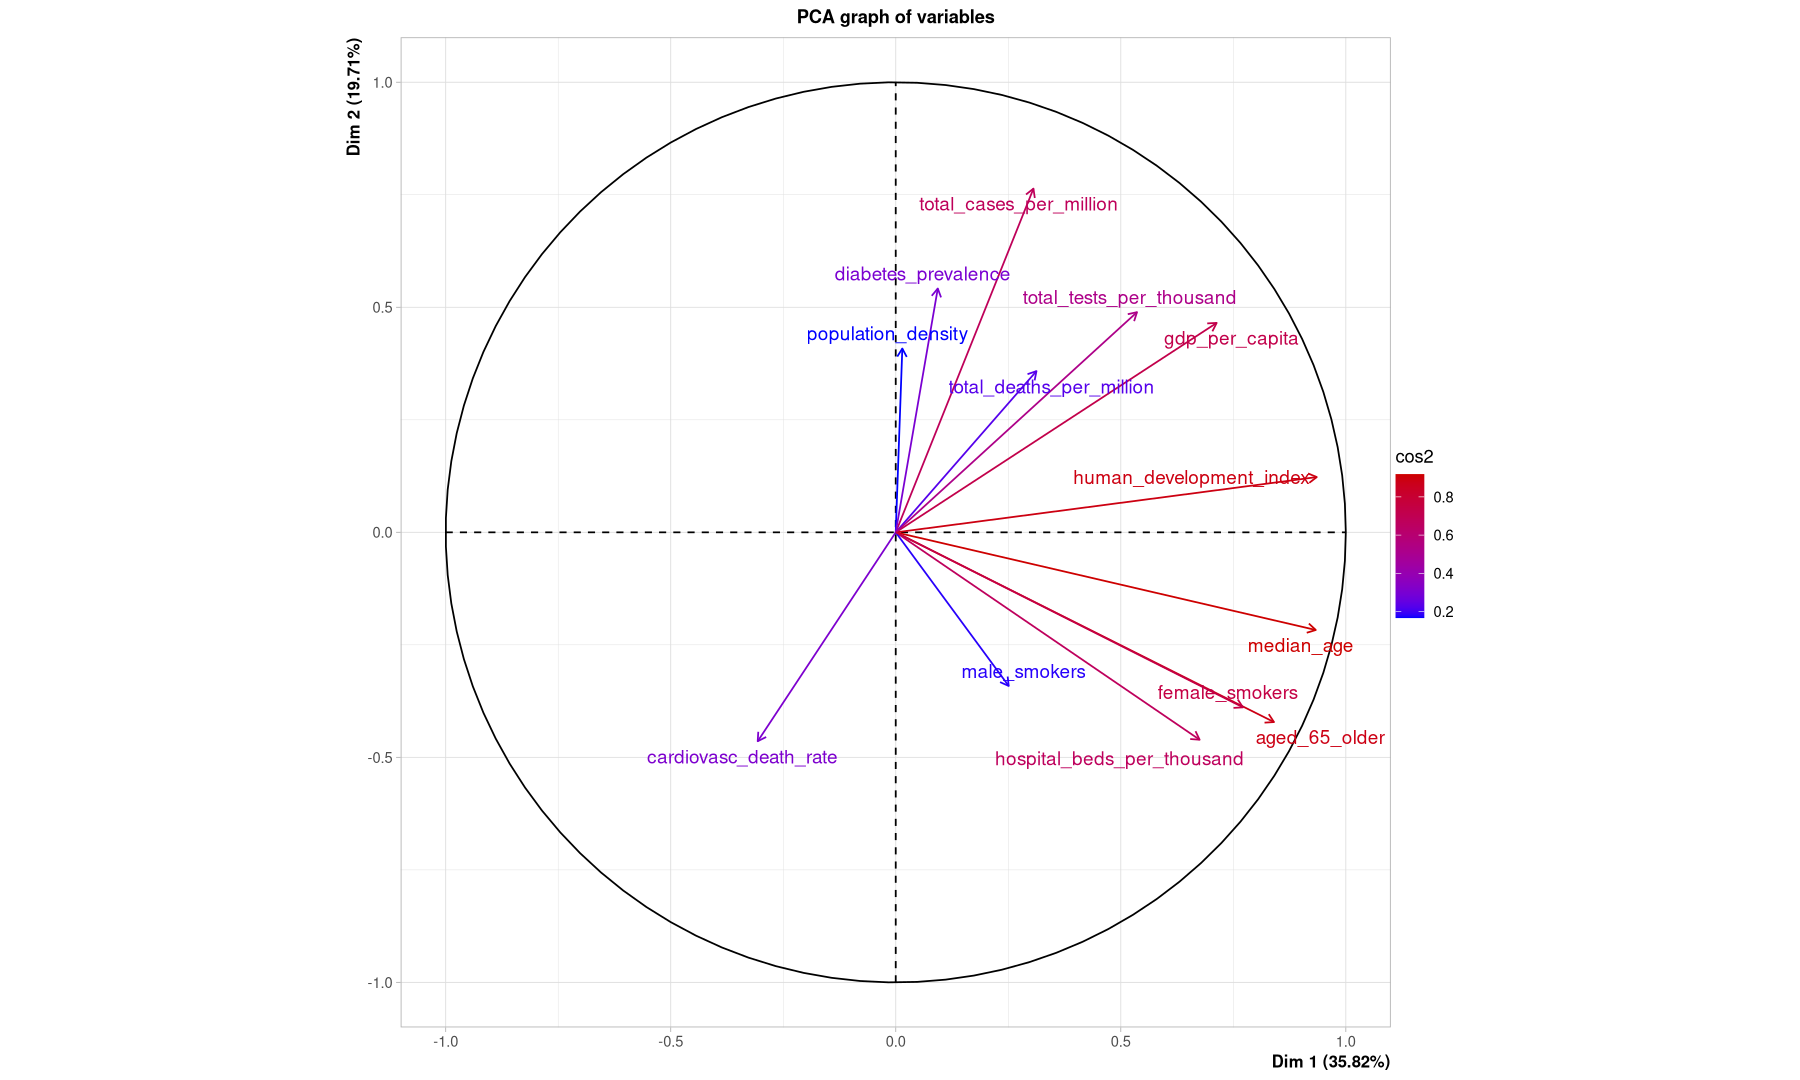

In [38]:
# Cercle des corrélations
plot(res.pca2, axes=c(1,2), choix="var", habillage="cos2")

À peu près le même graphique qu'auparavant, mais avec gdb_per_capita qui remonte, indiquant une plus fort corrélation avec total_cases_per_million. De plus, female_smokers et aged_65_older semblent très fortement corrélées. Vérifions cela :

In [60]:
cor(subset(d2, select=c("total_cases_per_million","gdp_per_capita","female_smokers","aged_65_older")))

total_cases_per_million gdp_per_capita female_smokers
total_cases_per_million  1.00000000             0.4996729      0.02316017    
gdp_per_capita           0.49967294             1.0000000      0.31217884    
female_smokers           0.02316017             0.3121788      1.00000000    
aged_65_older           -0.11638738             0.3434384      0.80954031    
                        aged_65_older
total_cases_per_million -0.1163874   
gdp_per_capita           0.3434384   
female_smokers           0.8095403   
aged_65_older            1.0000000

En effet donc, les pays comptant plus de personnes âgées (pas forcément les plus riches) ont aussi en général plus de femmes qui fument. Quand au PIB par habitant, il est assez nettement lié au nombre de cas : cela rejoint une observation précédente, et l'explication reste la même.

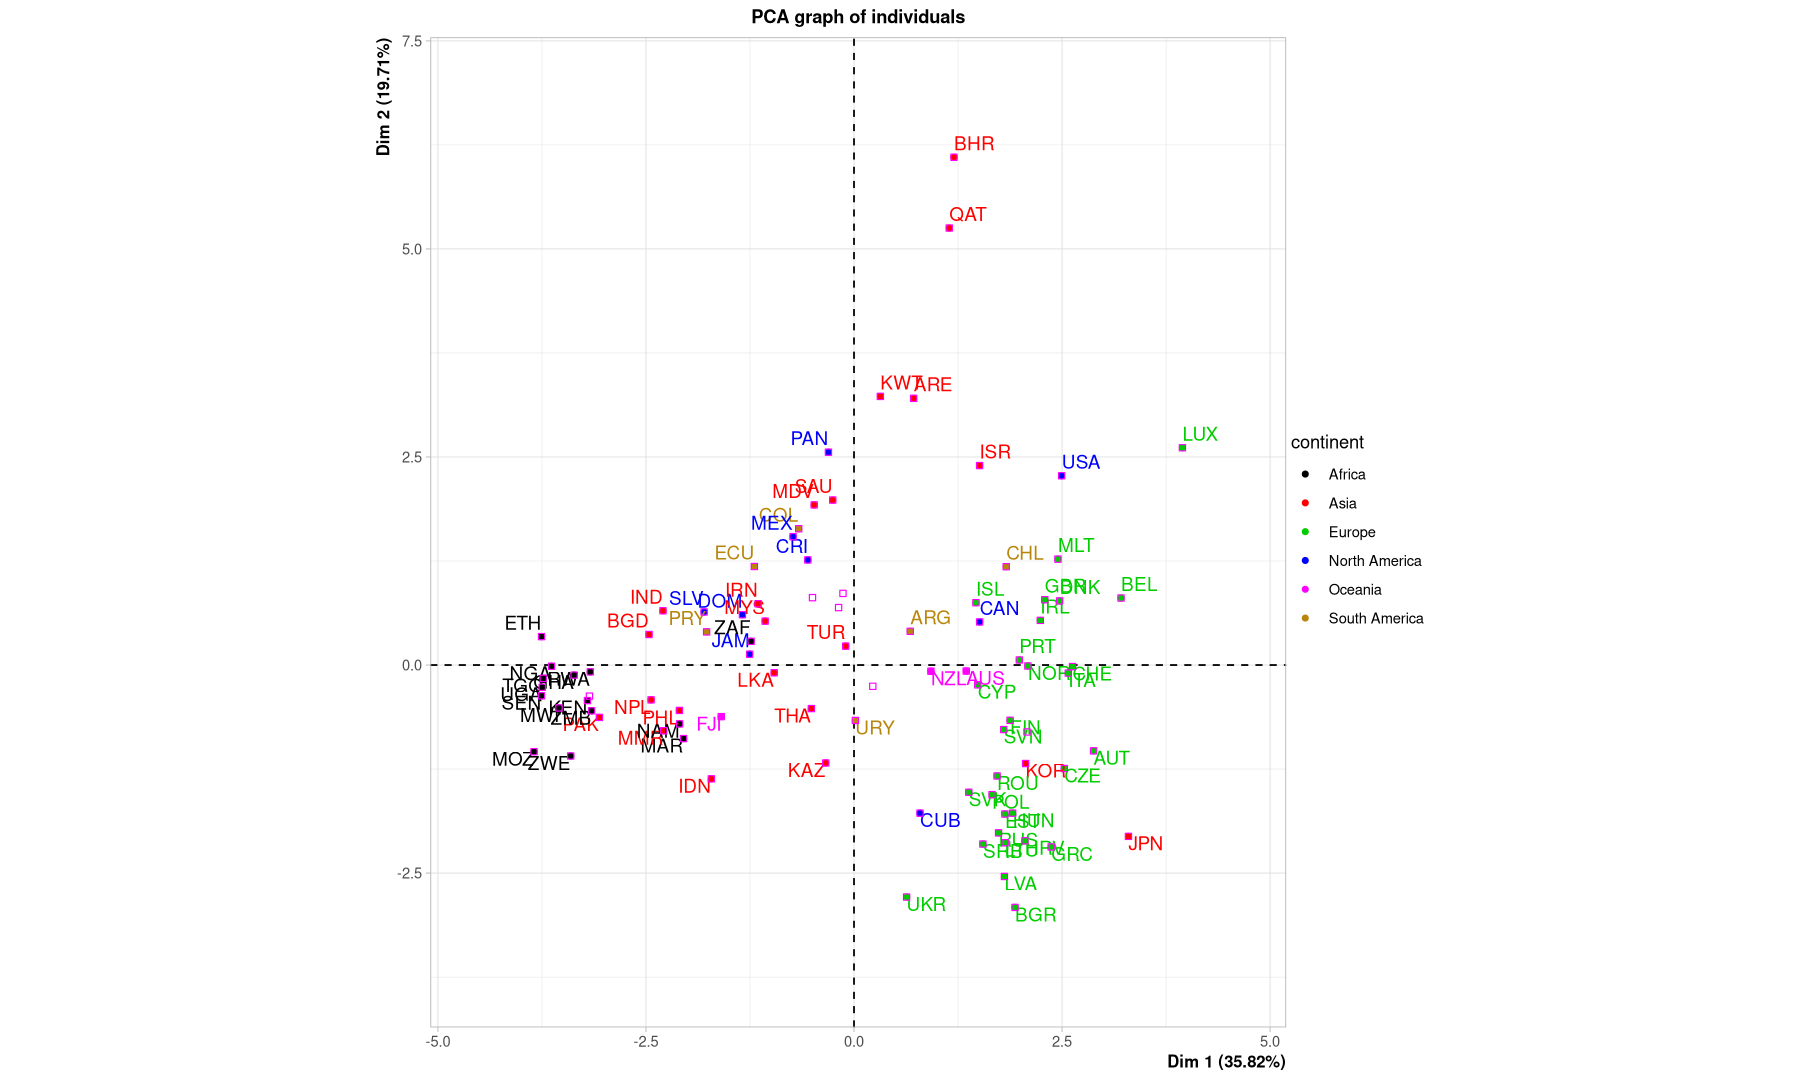

In [39]:
# Nuage des individus :
plot(res.pca2, axes=c(1,2), choix="ind", habillage=1, label="ind")

Le nuage comporte moins de points : compte-tenu des données manquantes, il ne reste que 84 individus sur les +180 initiaux. La répartition des pays est toutefois similaire : Europe à droite, Afrique à gauche - plus concentrée -, et les autres continents plutôt dispersés au centre. Notons tout de même une différence : l'Amérique du nords se retrouve nettement divisée en Canada-USA-Cuba et les autres pays : Mexique, Panama, République Dominicaine etc. Étant curieux de comprendre les différences par exemple entre Mexique, Panama et Cuba, regardons de plus près.

In [40]:
show_idx <- (1:nrow(d2))[rownames(d2) %in% c("MEX","PAN","CUB","USA")]
subset(d2[show_idx,], select=c("location", "median_age","human_development_index"))

location      median_age human_development_index
CUB Cuba          43.1       0.777                  
MEX Mexico        29.3       0.774                  
PAN Panama        29.7       0.789                  
USA United States 38.3       0.924

La réponse est assez claire : un âge médian nettement plus bas (de 10 ans environ) au Mexique et Panama. L'IDH des États-Unis est loin devant ceux des trois autres pays, expliquant son positionnement plus à droite. Cuba est légèrement à droite compte-tenu de son âge médian.

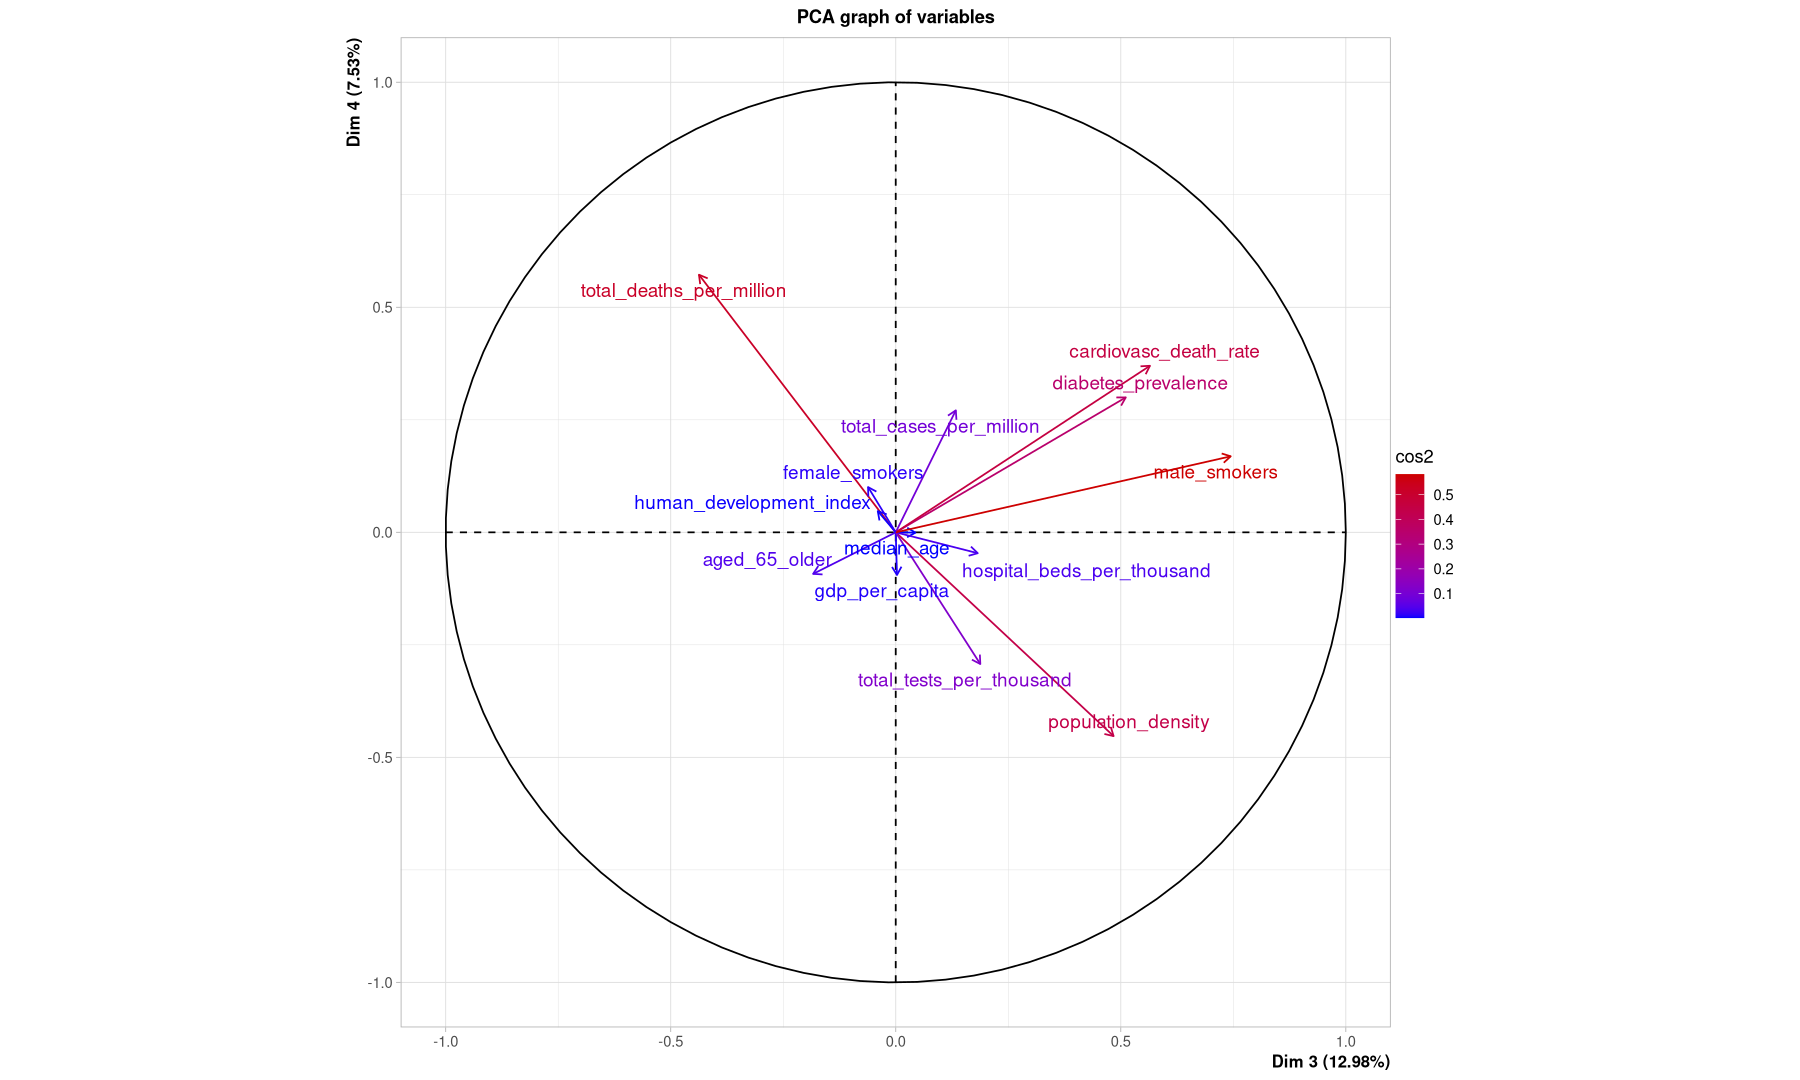

In [41]:
# Cercle des corrélations sur le plan 3-4 :
plot(res.pca2, axes=c(3,4), choix="var", habillage="cos2")

Résultat étonnant : le nombre de morts par millions semble négativement corrélé à la densité de population. Autrement dit, plus la densité est forte moins il y a de morts par million. C'est à relativiser car estimé sur 84 pays seulement, mais tout de même. Vérifions :

In [45]:
cor(d2[,3:6])

total_cases_per_million total_deaths_per_million
total_cases_per_million  1.00000000               0.46565828             
total_deaths_per_million 0.46565828               1.00000000             
population_density       0.33610223              -0.06884444             
median_age               0.08293562               0.18571445             
                         population_density median_age 
total_cases_per_million   0.33610223         0.08293562
total_deaths_per_million -0.06884444         0.18571445
population_density        1.00000000        -0.03368264
median_age               -0.03368264         1.00000000

Ce n'était donc qu'une illusion graphique : en fait le plan 3-4 n'explique qu'environ 20% de l'inertie totale, et dans ce plan les variables total_deaths_per_million et population_density sont en fait relativement mal projetées :

In [63]:
rowSums(res.pca2$var$cos2[2:3,3:4])

total_deaths_per_million       population_density 
               0.5187332                0.4392942

Conclusion : il faut se méfier des impressions visuelles et revenir aux données pour vérifier. C'est ce que l'on fait plus bas.

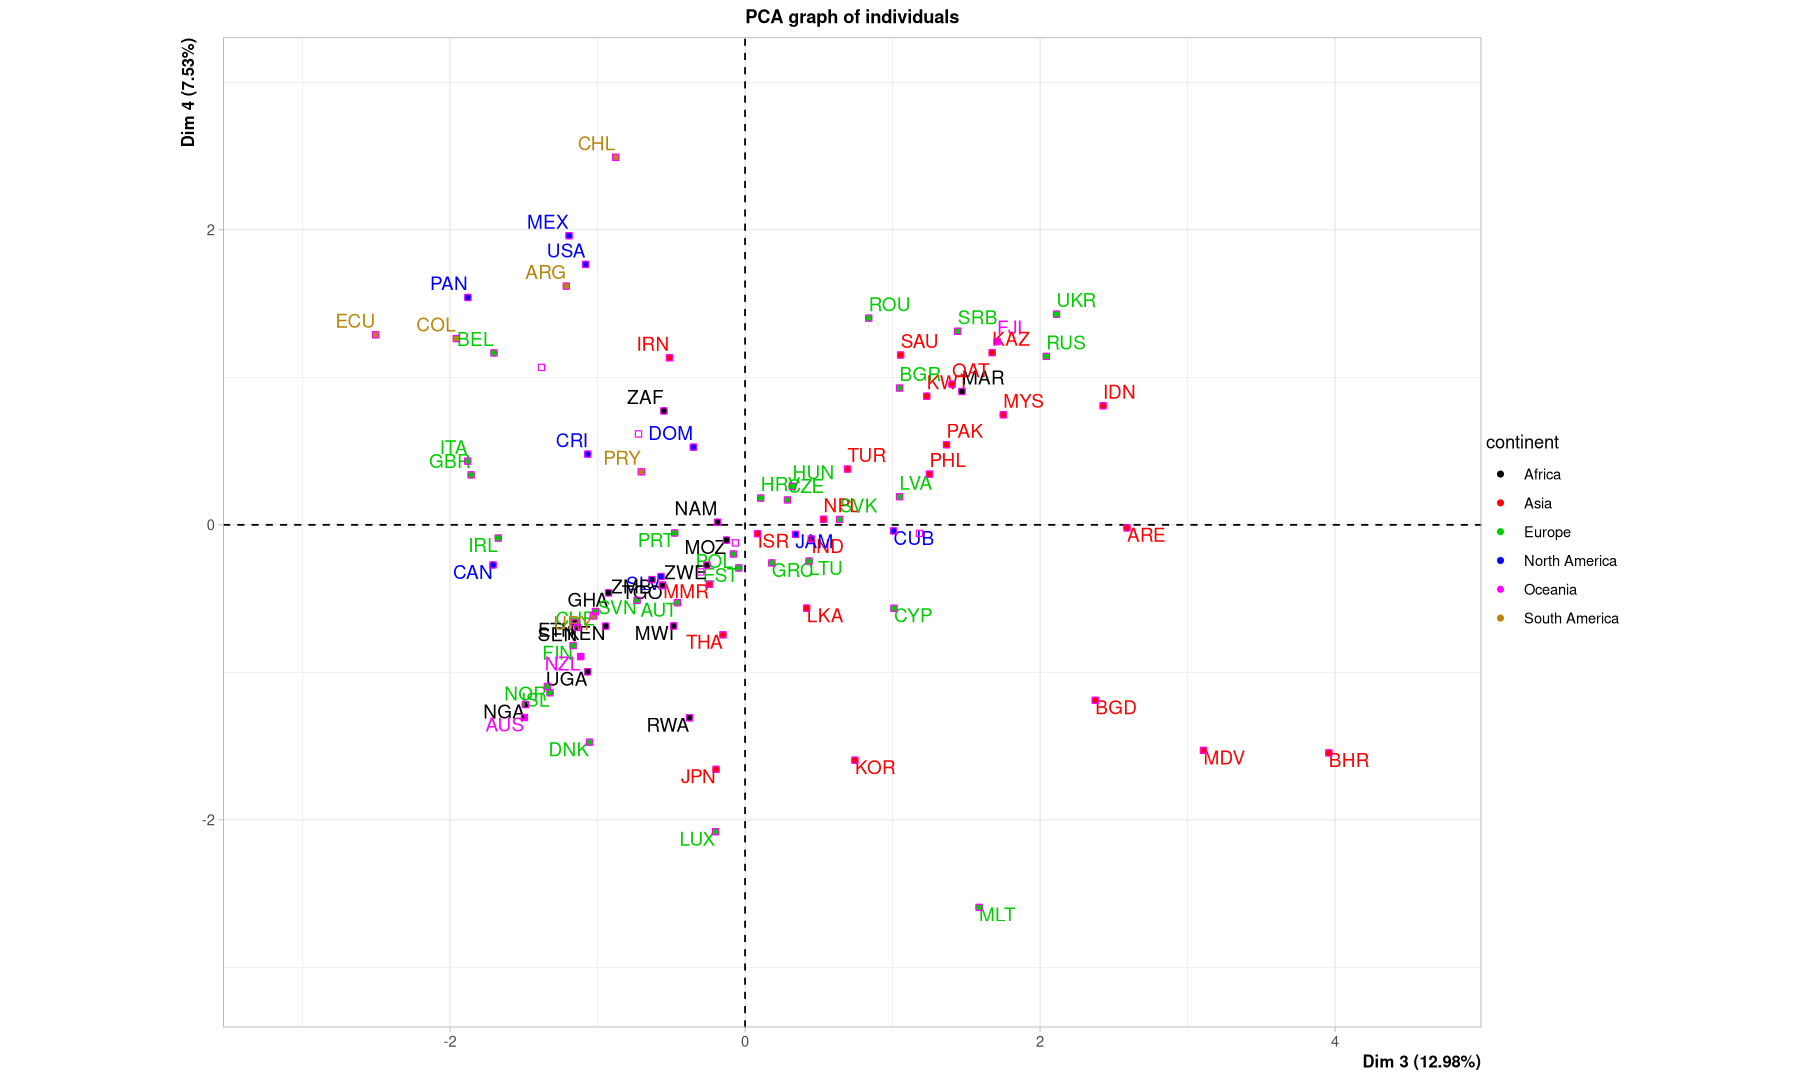

In [51]:
# Nuage des individus dans le plan 3-4 :
plot(res.pca2, axes=c(3,4), choix="ind", habillage=1, label="ind")

Un axe se dégage clairement, du sud-ouest au nord-est. D'après le cercle des corrélations il correspondrait aux variables cardiovasc_death_rate, diabete_prevalence et male_smokers. Examinons trois pays pris sur cet axe dans la direction des flèches : Australie, Israel et Ukraine.

In [56]:
show_idx <- (1:nrow(d2))[rownames(d2) %in% c("AUS","ISR","UKR")]
subset(d2[show_idx,], select=c("location", "cardiovasc_death_rate","diabetes_prevalence","male_smokers"))

location  cardiovasc_death_rate diabetes_prevalence male_smokers
AUS Australia 107.791               5.07                16.5        
ISR Israel     93.320               6.74                35.4        
UKR Ukraine   539.849               7.11                47.4

L'interprétation est vérifiée, sauf pour le taux de mortalité cardiovasculaire entre l'Australie et Israel.

Cherchons également à comprendre l'opposition sud-est / nord-ouest, en comparant deux individus extrêmes : Panama et les Maldives :

In [58]:
show_idx <- (1:nrow(d2))[rownames(d2) %in% c("PAN","MDV")]
subset(d2[show_idx,], select=c("location","total_deaths_per_million",
                               "population_density","total_tests_per_thousand","male_smokers"))

location total_deaths_per_million population_density
MDV Maldives  64.750                  1454.433          
PAN Panama   579.869                    55.133          
    total_tests_per_thousand male_smokers
MDV 318.617                  55.0        
PAN 127.560                   9.9

Ainsi, sur cet exemple l'opposition densité de population / nombre total de morts par millions est vérifiée. On peut supposer qu'elle est valide le long de cet axe dans ce plan seulement, avec d'un côté surtout des pays américains et de l'autre plutôt des pays asiatiques.

## Conclusion

Dans un premier temps, l'ACP sur les données initiales a montré - assez logiquement - que la richesse d'un pays (résumée par son HDI) est le principal critère le différenciant des autres. Les variables "covid" sont faiblement voire pas du tout liées aux variables descriptives. L'Amérique du Sud est globalement plus touchée que l'Afrique (continent jeune) et l'Europe (continent riche), probablement à cause d'une mauvaise gestion de l'épidémie - qui peut être liée entre autres à des lacunes dans le système de santé pour certains pays (Pérou, Brésil par exemple).

Dans un second temps, l'ajout de variables et la suppression de plus de la moitié des pays a mené à quelques autres observations :

 - corrélation gdp_per_capita avec total_cases_per_million plus marquée ;
 - forte corrélation female_smokers avec aged_65_older : les populations plus âgées ont plus de femmes fumeuses ;
 - population_density opposé à total_deaths_per_million dans le second plan ACP.

Je n'ai a priori pas vraiment d'explications à ces deux derniers points.